In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
import scipy.stats as st
from scipy.stats import probplot, ks_2samp

from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV, train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted
import missingno as msno
import xgboost as xgb, lightgbm as lgbm, catboost as catb

%matplotlib inline
import time
from typing import List, Optional
from sklearn.decomposition import PCA

import warnings
warnings.simplefilter("ignore")

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
import scipy.stats as st
from scipy.stats import probplot, ks_2samp

from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV, train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted
import missingno as msno
import xgboost as xgb
import catboost as cb
from sklearn.linear_model import LogisticRegression


%matplotlib inline

import warnings
warnings.simplefilter("ignore")


import time
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt

from tqdm import tqdm
from scipy.stats import gmean, rankdata
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, KFold

from boostaroota import BoostARoota

import shap
shap.initjs()

In [3]:
df_train = pd.read_csv('/Kaggle/input/geekbrains-competitive-data-analysis/train.csv')
df_test = pd.read_csv('/Kaggle/input/geekbrains-competitive-data-analysis/test.csv')
df_application = pd.read_csv('/Kaggle/input/geekbrains-competitive-data-analysis/applications_history.csv')
df_bki = pd.read_csv('/Kaggle/input/geekbrains-competitive-data-analysis/bki.csv')
df_client_profile = pd.read_csv('/Kaggle/input/geekbrains-competitive-data-analysis/client_profile.csv')
df_payments = pd.read_csv('/Kaggle/input/geekbrains-competitive-data-analysis/payments.csv')


In [4]:
df_train.head()

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE
0,123687442,0,Cash
1,123597908,1,Cash
2,123526683,0,Cash
3,123710391,1,Cash
4,123590329,1,Cash


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110093 entries, 0 to 110092
Data columns (total 3 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   APPLICATION_NUMBER  110093 non-null  int64 
 1   TARGET              110093 non-null  int64 
 2   NAME_CONTRACT_TYPE  110093 non-null  object
dtypes: int64(2), object(1)
memory usage: 2.5+ MB


In [6]:
df_test.head()

,APPLICATION_NUMBER,NAME_CONTRACT_TYPE
0,123724268,Cash
1,123456549,Cash
2,123428178,Credit Card
3,123619984,Cash
4,123671104,Cash


In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165141 entries, 0 to 165140
Data columns (total 2 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   APPLICATION_NUMBER  165141 non-null  int64 
 1   NAME_CONTRACT_TYPE  165141 non-null  object
dtypes: int64(1), object(1)
memory usage: 2.5+ MB


трейн и тест без пропусков. любопытный момент, что в тесте данных больше, чем в трейне. 

In [8]:
df_application.head()

,PREV_APPLICATION_NUMBER,APPLICATION_NUMBER,NAME_CONTRACT_TYPE,AMOUNT_ANNUITY,AMT_APPLICATION,AMOUNT_CREDIT,AMOUNT_PAYMENT,AMOUNT_GOODS_PAYMENT,NAME_CONTRACT_STATUS,DAYS_DECISION,...,NAME_PRODUCT_TYPE,SELLERPLACE_AREA,CNT_PAYMENT,NAME_YIELD_GROUP,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,49298709,123595216,NaN,1730.430,17145.0,17145.0,0.0,17145.0,Approved,73,...,XNA,35,12.0,middle,365243.0,42.0,300.0,42.0,37.0,0.0
1,50070639,123431468,Cash,25188.615,607500.0,679671.0,NaN,607500.0,Approved,164,...,x-sell,-1,36.0,low_action,365243.0,134.0,916.0,365243.0,365243.0,1.0
2,49791680,123445379,Cash,15060.735,112500.0,136444.5,NaN,112500.0,Approved,301,...,x-sell,-1,12.0,high,365243.0,271.0,59.0,365243.0,365243.0,1.0
3,50087457,123499497,Cash,47041.335,450000.0,470790.0,NaN,450000.0,Approved,512,...,x-sell,-1,12.0,middle,365243.0,482.0,152.0,182.0,177.0,1.0
4,49052479,123525393,Cash,31924.395,337500.0,404055.0,NaN,337500.0,Refused,781,...,walk-in,-1,24.0,high,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
df_application.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 26 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   PREV_APPLICATION_NUMBER    1670214 non-null  int64  
 1   APPLICATION_NUMBER         1670214 non-null  int64  
 2   NAME_CONTRACT_TYPE         940717 non-null   object 
 3   AMOUNT_ANNUITY             1297979 non-null  float64
 4   AMT_APPLICATION            1670214 non-null  float64
 5   AMOUNT_CREDIT              1670213 non-null  float64
 6   AMOUNT_PAYMENT             774370 non-null   float64
 7   AMOUNT_GOODS_PAYMENT       1284699 non-null  float64
 8   NAME_CONTRACT_STATUS       1670214 non-null  object 
 9   DAYS_DECISION              1670214 non-null  int64  
 10  NAME_PAYMENT_TYPE          1670214 non-null  object 
 11  CODE_REJECT_REASON         1670214 non-null  object 
 12  NAME_TYPE_SUITE            849809 non-null   object 
 13  NAME_CLIENT_

In [10]:
df_bki.head()

,APPLICATION_NUMBER,BUREAU_ID,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,123538884,5223613,Active,currency 1,718.0,0,377.0,NaN,19386.81,0,675000.00,320265.495,0.0,0.0,Consumer credit,39.0,NaN
1,123436670,6207544,Closed,currency 1,696.0,0,511.0,511.0,0.00,0,93111.66,0.000,0.0,0.0,Consumer credit,505.0,NaN
2,123589020,6326395,Closed,currency 1,165.0,0,149.0,160.0,NaN,0,36000.00,0.000,0.0,0.0,Consumer credit,150.0,0.0
3,123494590,6606618,Active,currency 1,55.0,0,310.0,NaN,NaN,0,38664.00,37858.500,NaN,0.0,Consumer credit,15.0,NaN
4,123446603,5046832,Active,currency 1,358.0,0,35.0,NaN,NaN,0,67500.00,0.000,0.0,0.0,Credit card,116.0,NaN


In [11]:
df_bki.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 945234 entries, 0 to 945233
Data columns (total 17 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   APPLICATION_NUMBER      945234 non-null  int64  
 1   BUREAU_ID               945234 non-null  int64  
 2   CREDIT_ACTIVE           945234 non-null  object 
 3   CREDIT_CURRENCY         945234 non-null  object 
 4   DAYS_CREDIT             945234 non-null  float64
 5   CREDIT_DAY_OVERDUE      945234 non-null  int64  
 6   DAYS_CREDIT_ENDDATE     886797 non-null  float64
 7   DAYS_ENDDATE_FACT       596274 non-null  float64
 8   AMT_CREDIT_MAX_OVERDUE  326557 non-null  float64
 9   CNT_CREDIT_PROLONG      945234 non-null  int64  
 10  AMT_CREDIT_SUM          945229 non-null  float64
 11  AMT_CREDIT_SUM_DEBT     803483 non-null  float64
 12  AMT_CREDIT_SUM_LIMIT    619267 non-null  float64
 13  AMT_CREDIT_SUM_OVERDUE  945234 non-null  float64
 14  CREDIT_TYPE         

In [12]:
df_client_profile.head()

,APPLICATION_NUMBER,GENDER,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,FAMILY_STATUS,REGION_POPULATION,AGE,...,FAMILY_SIZE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,123666076,F,0,157500.0,270000.0,13500.0,Incomplete higher,Civil marriage,0.008068,8560,...,2.0,0.329471,0.236315,0.678568,0.0,0.0,0.0,0.0,1.0,2.0
1,123423688,F,0,270000.0,536917.5,28467.0,Secondary / secondary special,Married,0.020246,23187,...,2.0,NaN,0.442295,0.802745,0.0,0.0,0.0,0.0,1.0,1.0
2,123501780,M,1,427500.0,239850.0,23850.0,Incomplete higher,Married,0.072508,14387,...,3.0,0.409017,0.738159,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,123588799,M,0,112500.0,254700.0,17149.5,Secondary / secondary special,Married,0.019101,14273,...,2.0,NaN,0.308994,0.590233,0.0,0.0,0.0,0.0,0.0,3.0
4,123647485,M,0,130500.0,614574.0,19822.5,Lower secondary,Married,0.022625,22954,...,2.0,NaN,0.739408,0.156640,0.0,0.0,1.0,0.0,0.0,6.0


In [13]:
df_client_profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 24 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   APPLICATION_NUMBER          250000 non-null  int64  
 1   GENDER                      250000 non-null  object 
 2   CHILDRENS                   250000 non-null  int64  
 3   TOTAL_SALARY                250000 non-null  float64
 4   AMOUNT_CREDIT               250000 non-null  float64
 5   AMOUNT_ANNUITY              249989 non-null  float64
 6   EDUCATION_LEVEL             250000 non-null  object 
 7   FAMILY_STATUS               250000 non-null  object 
 8   REGION_POPULATION           250000 non-null  float64
 9   AGE                         250000 non-null  int64  
 10  DAYS_ON_LAST_JOB            250000 non-null  int64  
 11  OWN_CAR_AGE                 85041 non-null   float64
 12  FLAG_PHONE                  250000 non-null  int64  
 13  FLAG_EMAIL    

In [14]:
df_payments.head()

,PREV_APPLICATION_NUMBER,APPLICATION_NUMBER,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,49011181,123664960,1.0,5,1002.0,1015.0,12156.615,12156.615
1,48683432,123497205,1.0,13,442.0,432.0,18392.535,10047.645
2,48652024,123749925,1.0,10,8.0,23.0,5499.945,5499.945
3,48398897,123550846,0.0,82,398.0,398.0,7082.145,7082.145
4,49867197,123562174,0.0,63,1359.0,1359.0,156.735,156.735


In [15]:
df_payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1023932 entries, 0 to 1023931
Data columns (total 8 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   PREV_APPLICATION_NUMBER  1023932 non-null  int64  
 1   APPLICATION_NUMBER       1023932 non-null  int64  
 2   NUM_INSTALMENT_VERSION   1023932 non-null  float64
 3   NUM_INSTALMENT_NUMBER    1023932 non-null  int64  
 4   DAYS_INSTALMENT          1023932 non-null  float64
 5   DAYS_ENTRY_PAYMENT       1023729 non-null  float64
 6   AMT_INSTALMENT           1023932 non-null  float64
 7   AMT_PAYMENT              1023729 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 62.5 MB


In [16]:
df_train_merged = pd.merge(df_train, df_application, on=('APPLICATION_NUMBER'))


In [17]:
df_train_merged

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE_x,PREV_APPLICATION_NUMBER,NAME_CONTRACT_TYPE_y,AMOUNT_ANNUITY,AMT_APPLICATION,AMOUNT_CREDIT,AMOUNT_PAYMENT,AMOUNT_GOODS_PAYMENT,...,NAME_PRODUCT_TYPE,SELLERPLACE_AREA,CNT_PAYMENT,NAME_YIELD_GROUP,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,123687442,0,Cash,49915814,NaN,6510.015,71668.800,64500.3,7168.500,71668.800,...,XNA,20,12.0,middle,365243.0,143.0,187.0,365243.0,365243.0,0.0
1,123687442,0,Cash,49713743,NaN,9262.215,72634.140,70758.0,7267.140,72634.140,...,XNA,90,10.0,high,365243.0,2671.0,2401.0,2401.0,2368.0,1.0
2,123687442,0,Cash,49704707,NaN,7339.185,62058.600,67518.0,3.600,62058.600,...,XNA,150,10.0,low_action,365243.0,690.0,420.0,420.0,415.0,0.0
3,123597908,1,Cash,48716994,Cash,38667.600,495000.000,672948.0,NaN,495000.000,...,x-sell,-1,36.0,high,NaN,NaN,NaN,NaN,NaN,NaN
4,123597908,1,Cash,49672074,NaN,11349.900,75510.000,82156.5,0.000,75510.000,...,XNA,12,10.0,high,365243.0,690.0,420.0,420.0,413.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
516110,123723001,0,Cash,49650758,NaN,4998.645,34245.000,27207.0,8563.500,34245.000,...,XNA,156,6.0,low_normal,365243.0,160.0,10.0,40.0,34.0,1.0
516111,123723001,0,Cash,49065356,NaN,3001.950,26482.500,29281.5,0.000,26482.500,...,XNA,156,12.0,middle,365243.0,708.0,378.0,558.0,526.0,0.0
516112,123554358,0,Cash,49515687,NaN,20264.805,261180.000,287037.0,0.000,261180.000,...,XNA,100,18.0,middle,365243.0,815.0,305.0,305.0,303.0,0.0
516113,123554358,0,Cash,49102720,Cash,29256.615,337500.000,368685.0,NaN,337500.000,...,walk-in,32,24.0,high,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
df_application[df_application['APPLICATION_NUMBER'] == 123687442]

,PREV_APPLICATION_NUMBER,APPLICATION_NUMBER,NAME_CONTRACT_TYPE,AMOUNT_ANNUITY,AMT_APPLICATION,AMOUNT_CREDIT,AMOUNT_PAYMENT,AMOUNT_GOODS_PAYMENT,NAME_CONTRACT_STATUS,DAYS_DECISION,...,NAME_PRODUCT_TYPE,SELLERPLACE_AREA,CNT_PAYMENT,NAME_YIELD_GROUP,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
239762,49915814,123687442,NaN,6510.015,71668.80,64500.3,7168.50,71668.80,Approved,240,...,XNA,20,12.0,middle,365243.0,143.0,187.0,365243.0,365243.0,0.0
509872,49713743,123687442,NaN,9262.215,72634.14,70758.0,7267.14,72634.14,Approved,2702,...,XNA,90,10.0,high,365243.0,2671.0,2401.0,2401.0,2368.0,1.0
626049,49704707,123687442,NaN,7339.185,62058.60,67518.0,3.60,62058.60,Approved,721,...,XNA,150,10.0,low_action,365243.0,690.0,420.0,420.0,415.0,0.0


мы видим, что к одному номеру заявки относится несколько история из нескольких заявок, которую нужно дополнительно обработать. иначе таблица трейна и теста у нас разбухает от данных. пока оставим ее, попробуем объединить с другими таблицами.

In [19]:
df_train_merged = pd.merge(df_train, df_bki, on=('APPLICATION_NUMBER'))


In [20]:
df_train_merged.head()

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE,BUREAU_ID,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,123687442,0,Cash,5640206,Closed,currency 1,2562.0,0,2197.0,2162.0,4714.425,0,56362.5,0.0,0.0,0.0,Consumer credit,2162.0,NaN
1,123597908,1,Cash,5970760,Closed,currency 1,1809.0,0,1475.0,1503.0,NaN,0,56376.0,0.0,NaN,0.0,Consumer credit,731.0,NaN
2,123597908,1,Cash,5923029,Closed,currency 1,434.0,0,130.0,130.0,0.000,0,137910.6,0.0,0.0,0.0,Consumer credit,126.0,NaN
3,123597908,1,Cash,5952522,Active,currency 1,141.0,0,225.0,NaN,NaN,0,264010.5,181561.5,0.0,0.0,Consumer credit,10.0,NaN
4,123597908,1,Cash,5912683,Closed,currency 1,1213.0,0,86.0,98.0,NaN,0,294615.0,0.0,NaN,0.0,Consumer credit,83.0,NaN


In [21]:
df_bki[df_bki['APPLICATION_NUMBER'] == 123597908]

,APPLICATION_NUMBER,BUREAU_ID,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
14729,123597908,5970760,Closed,currency 1,1809.0,0,1475.0,1503.0,NaN,0,56376.0,0.0,NaN,0.0,Consumer credit,731.0,NaN
31667,123597908,5923029,Closed,currency 1,434.0,0,130.0,130.0,0.000,0,137910.6,0.0,0.0,0.0,Consumer credit,126.0,NaN
57336,123597908,5952522,Active,currency 1,141.0,0,225.0,NaN,NaN,0,264010.5,181561.5,0.0,0.0,Consumer credit,10.0,NaN
540054,123597908,5912683,Closed,currency 1,1213.0,0,86.0,98.0,NaN,0,294615.0,0.0,NaN,0.0,Consumer credit,83.0,NaN
758192,123597908,5974372,Active,currency 1,150.0,0,215.0,NaN,0.000,0,106200.0,76248.0,0.0,0.0,Consumer credit,27.0,NaN
772547,123597908,5990570,Closed,currency 1,1832.0,0,1745.0,1042.0,NaN,0,21829.5,NaN,NaN,0.0,Consumer credit,1039.0,NaN
820607,123597908,5898408,Active,currency 1,57.0,0,127.0,NaN,0.000,0,63202.5,53667.0,0.0,0.0,Consumer credit,24.0,NaN
853827,123597908,5980412,Active,currency 1,1630.0,0,1326.0,NaN,16639.155,0,162400.5,0.0,0.0,0.0,Consumer credit,27.0,NaN
896743,123597908,5964293,Closed,currency 1,560.0,0,195.0,181.0,17985.915,0,178650.0,0.0,0.0,0.0,Consumer credit,181.0,NaN


данных по предыдущим кредитам также может быть несколько на каждый номер заявки. 

In [22]:
df_train_merged = pd.merge(df_train, df_client_profile, on=('APPLICATION_NUMBER'), how ='left')

In [23]:
df_train_merged

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE,GENDER,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,FAMILY_STATUS,...,FAMILY_SIZE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,123687442,0,Cash,M,1.0,157500.0,855000.0,25128.0,Secondary / secondary special,Married,...,3.0,0.700784,0.645914,0.716570,0.0,0.0,1.0,0.0,0.0,2.0
1,123597908,1,Cash,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,123526683,0,Cash,F,0.0,135000.0,1006920.0,42660.0,Higher education,Married,...,2.0,NaN,0.682149,0.267869,0.0,0.0,0.0,7.0,0.0,4.0
3,123710391,1,Cash,M,0.0,180000.0,518562.0,22972.5,Secondary / secondary special,Married,...,2.0,NaN,0.171299,0.170446,0.0,0.0,0.0,0.0,0.0,0.0
4,123590329,1,Cash,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110088,123458312,0,Cash,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
110089,123672463,0,Cash,F,0.0,175500.0,269550.0,12618.0,Secondary / secondary special,Married,...,2.0,0.528096,0.471774,0.581484,0.0,0.0,0.0,0.0,0.0,2.0
110090,123723001,0,Cash,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
110091,123554358,0,Cash,F,2.0,270000.0,1024740.0,49428.0,Incomplete higher,Married,...,4.0,0.653826,0.651227,0.558507,0.0,0.0,0.0,1.0,0.0,1.0


Здесь обратная картина - части данных из теста нет в базе профилей, поэтому размер данных стал меньше на 20000 наблюдений. Можно их попробовать заполнить, но качество данных от этого не увеличится. Поэтому ими лучше пренебречь

In [24]:
df_train_merged = pd.merge(df_train, df_client_profile, on=('APPLICATION_NUMBER'))


In [25]:
df_train_merged

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE,GENDER,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,FAMILY_STATUS,...,FAMILY_SIZE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,123687442,0,Cash,M,1,157500.0,855000.0,25128.0,Secondary / secondary special,Married,...,3.0,0.700784,0.645914,0.716570,0.0,0.0,1.0,0.0,0.0,2.0
1,123526683,0,Cash,F,0,135000.0,1006920.0,42660.0,Higher education,Married,...,2.0,NaN,0.682149,0.267869,0.0,0.0,0.0,7.0,0.0,4.0
2,123710391,1,Cash,M,0,180000.0,518562.0,22972.5,Secondary / secondary special,Married,...,2.0,NaN,0.171299,0.170446,0.0,0.0,0.0,0.0,0.0,0.0
3,123718821,0,Cash,F,1,180000.0,755190.0,36459.0,Secondary / secondary special,Married,...,3.0,NaN,0.548504,0.331251,1.0,0.0,0.0,0.0,0.0,2.0
4,123544624,0,Cash,M,0,202500.0,1078200.0,38331.0,Secondary / secondary special,Married,...,2.0,NaN,0.547421,0.740799,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89534,123595479,0,Cash,F,0,225000.0,990432.0,32863.5,Secondary / secondary special,Separated,...,1.0,0.768198,0.713399,0.529890,0.0,0.0,0.0,0.0,0.0,0.0
89535,123426326,0,Cash,F,2,135000.0,995643.0,32904.0,Secondary / secondary special,Married,...,4.0,0.410920,0.592042,0.570917,0.0,0.0,0.0,0.0,0.0,1.0
89536,123672463,0,Cash,F,0,175500.0,269550.0,12618.0,Secondary / secondary special,Married,...,2.0,0.528096,0.471774,0.581484,0.0,0.0,0.0,0.0,0.0,2.0
89537,123554358,0,Cash,F,2,270000.0,1024740.0,49428.0,Incomplete higher,Married,...,4.0,0.653826,0.651227,0.558507,0.0,0.0,0.0,1.0,0.0,1.0


In [26]:
df_train_merged = pd.merge(df_train, df_payments, on=('APPLICATION_NUMBER'))


In [27]:
df_train_merged

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE,PREV_APPLICATION_NUMBER,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,123687442,0,Cash,49796018,1.0,4,2830.0,2830.0,3289.635,3289.635
1,123687442,0,Cash,49796018,1.0,7,2740.0,2740.0,3289.635,3289.635
2,123687442,0,Cash,49713743,1.0,5,2551.0,2547.0,9262.215,9251.865
3,123687442,0,Cash,49713743,1.0,7,2491.0,2519.0,9262.215,10.350
4,123597908,1,Cash,49672074,1.0,9,450.0,457.0,11349.900,11349.900
...,...,...,...,...,...,...,...,...,...,...
316934,123672463,0,Cash,48886788,1.0,1,160.0,186.0,3135.240,13500.000
316935,123672463,0,Cash,48503461,1.0,3,1439.0,1433.0,4323.510,4321.530
316936,123723001,0,Cash,49650758,1.0,4,70.0,83.0,4998.645,4998.645
316937,123676265,0,Credit Card,49159579,1.0,5,2431.0,2443.0,15902.910,15902.910


In [28]:
df_payments[df_payments['APPLICATION_NUMBER'] == 123687442]

,PREV_APPLICATION_NUMBER,APPLICATION_NUMBER,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
65196,49796018,123687442,1.0,4,2830.0,2830.0,3289.635,3289.635
79322,49796018,123687442,1.0,7,2740.0,2740.0,3289.635,3289.635
693273,49713743,123687442,1.0,5,2551.0,2547.0,9262.215,9251.865
726215,49713743,123687442,1.0,7,2491.0,2519.0,9262.215,10.350


In [29]:
df_application = df_application.groupby(['APPLICATION_NUMBER']).mean().reset_index()

#df_application[df_application['APPLICATION_NUMBER'] == 123687442]

In [30]:
df_application

,APPLICATION_NUMBER,PREV_APPLICATION_NUMBER,AMOUNT_ANNUITY,AMT_APPLICATION,AMOUNT_CREDIT,AMOUNT_PAYMENT,AMOUNT_GOODS_PAYMENT,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,123423340,4.863791e+07,3951.000000,24835.500,23787.00,2520.00,24835.500,1740.000,23.000,8.00,365243.0,1709.000000,1499.000000,1619.000000,1612.000000,0.000000
1,123423341,4.830703e+07,9251.775000,179055.000,179055.00,0.00,179055.000,606.000,500.000,24.00,365243.0,565.000000,125.000000,25.000000,17.000000,0.000000
2,123423342,4.954936e+07,56553.990000,435436.500,484191.00,3442.50,435436.500,1305.000,533.000,10.00,365243.0,1274.333333,1004.333333,1054.333333,1047.333333,0.666667
3,123423343,4.883223e+07,5357.250000,24282.000,20106.00,4860.00,24282.000,815.000,30.000,4.00,365243.0,784.000000,694.000000,724.000000,714.000000,0.000000
4,123423344,4.944505e+07,4813.200000,22308.750,20076.75,4464.00,44617.500,536.000,18.000,12.00,365243.0,706.000000,376.000000,466.000000,460.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
338852,123779590,4.951623e+07,6605.910000,40455.000,40455.00,0.00,40455.000,273.000,30.000,8.00,365243.0,210.000000,0.000000,30.000000,25.000000,0.000000
338853,123779591,4.877181e+07,10074.465000,57595.500,56821.50,3456.00,57595.500,2497.000,190.000,6.00,365243.0,2466.000000,2316.000000,2316.000000,2311.000000,1.000000
338854,123779592,4.894544e+07,4770.405000,24162.750,20625.75,4403.25,24162.750,2380.000,22.000,5.00,365243.0,2339.000000,2219.000000,2219.000000,2212.500000,0.500000
338855,123779593,4.917287e+07,10681.132500,121317.750,134439.75,0.00,121317.750,299.500,1578.000,15.00,365243.0,269.000000,151.000000,365243.000000,365243.000000,0.500000


In [31]:
df_application[df_application['APPLICATION_NUMBER'] == 123687442]

,APPLICATION_NUMBER,PREV_APPLICATION_NUMBER,AMOUNT_ANNUITY,AMT_APPLICATION,AMOUNT_CREDIT,AMOUNT_PAYMENT,AMOUNT_GOODS_PAYMENT,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
251104,123687442,49778088.0,7703.805,68787.18,67592.1,4813.08,68787.18,1221.0,86.666667,10.666667,365243.0,1168.0,1002.666667,122688.0,122675.333333,0.333333


In [32]:
df_application = df_application.drop(['PREV_APPLICATION_NUMBER'], axis=1)

In [33]:
df_bki = df_bki.groupby(['APPLICATION_NUMBER']).mean().reset_index()
df_bki[df_bki['APPLICATION_NUMBER'] == 123597908]

,APPLICATION_NUMBER,BUREAU_ID,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
133899,123597908,5.951894e+06,869.555556,0.0,613.777778,590.8,6925.014,0.0,142799.4,38934.5625,0.0,0.0,249.777778,NaN


In [34]:
df_bki = df_bki.drop(['BUREAU_ID'], axis=1)

In [35]:
df_payments = df_payments.groupby(['APPLICATION_NUMBER']).mean().reset_index()


In [36]:
df_payments[df_payments['APPLICATION_NUMBER'] == 123687442]

,APPLICATION_NUMBER,PREV_APPLICATION_NUMBER,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
195985,123687442,49754880.5,1.0,5.75,2653.0,2659.0,6275.925,3960.37125


In [37]:
df_payments = df_payments.drop(['PREV_APPLICATION_NUMBER'], axis=1)

In [38]:
df_train_merged = pd.merge(df_train, df_client_profile, on=('APPLICATION_NUMBER'), how ='left')

In [39]:
df_train_merged

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE,GENDER,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,FAMILY_STATUS,...,FAMILY_SIZE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,123687442,0,Cash,M,1.0,157500.0,855000.0,25128.0,Secondary / secondary special,Married,...,3.0,0.700784,0.645914,0.716570,0.0,0.0,1.0,0.0,0.0,2.0
1,123597908,1,Cash,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,123526683,0,Cash,F,0.0,135000.0,1006920.0,42660.0,Higher education,Married,...,2.0,NaN,0.682149,0.267869,0.0,0.0,0.0,7.0,0.0,4.0
3,123710391,1,Cash,M,0.0,180000.0,518562.0,22972.5,Secondary / secondary special,Married,...,2.0,NaN,0.171299,0.170446,0.0,0.0,0.0,0.0,0.0,0.0
4,123590329,1,Cash,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110088,123458312,0,Cash,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
110089,123672463,0,Cash,F,0.0,175500.0,269550.0,12618.0,Secondary / secondary special,Married,...,2.0,0.528096,0.471774,0.581484,0.0,0.0,0.0,0.0,0.0,2.0
110090,123723001,0,Cash,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
110091,123554358,0,Cash,F,2.0,270000.0,1024740.0,49428.0,Incomplete higher,Married,...,4.0,0.653826,0.651227,0.558507,0.0,0.0,0.0,1.0,0.0,1.0


In [40]:
df_test_merged = pd.merge(df_test, df_client_profile, on=('APPLICATION_NUMBER'), how ='left')

In [41]:
df_test_merged

,APPLICATION_NUMBER,NAME_CONTRACT_TYPE,GENDER,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,FAMILY_STATUS,REGION_POPULATION,...,FAMILY_SIZE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,123724268,Cash,M,0.0,117000.0,1125000.0,32895.0,Secondary / secondary special,Married,0.028663,...,2.0,NaN,0.628266,NaN,0.0,0.0,0.0,0.0,1.0,4.0
1,123456549,Cash,F,2.0,81000.0,312768.0,17095.5,Secondary / secondary special,Married,0.019689,...,4.0,NaN,0.578161,0.188490,0.0,0.0,1.0,0.0,0.0,2.0
2,123428178,Credit Card,F,2.0,157500.0,450000.0,22500.0,Secondary / secondary special,Married,0.019101,...,4.0,NaN,0.152544,0.382502,0.0,0.0,0.0,0.0,1.0,6.0
3,123619984,Cash,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,123671104,Cash,F,1.0,90000.0,254700.0,24939.0,Higher education,Married,0.015221,...,3.0,0.718604,0.505704,0.415347,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165136,123487967,Cash,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
165137,123536402,Cash,M,0.0,135000.0,450000.0,16807.5,Secondary / secondary special,Single / not married,0.028663,...,1.0,NaN,0.665971,0.535276,0.0,0.0,0.0,0.0,0.0,0.0
165138,123718238,Cash,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
165139,123631557,Cash,F,0.0,112500.0,350181.0,36769.5,Secondary / secondary special,Married,0.030755,...,2.0,NaN,0.761376,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Объединение таблиц завершено, теперь можно приступить к анализу данных. 

In [42]:
numerical_features = df_train_merged.select_dtypes(include=[np.number])

print(f"count of numeric_features {numerical_features.shape[1]}")
numerical_features.columns

count of numeric_features 22


Index(['APPLICATION_NUMBER', 'TARGET', 'CHILDRENS', 'TOTAL_SALARY',
       'AMOUNT_CREDIT', 'AMOUNT_ANNUITY', 'REGION_POPULATION', 'AGE',
       'DAYS_ON_LAST_JOB', 'OWN_CAR_AGE', 'FLAG_PHONE', 'FLAG_EMAIL',
       'FAMILY_SIZE', 'EXTERNAL_SCORING_RATING_1', 'EXTERNAL_SCORING_RATING_2',
       'EXTERNAL_SCORING_RATING_3', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object')

In [43]:
categorical_features = df_train_merged.select_dtypes(include=[np.object])
print(f"Categorical Feature Count {categorical_features.shape[1]}")
categorical_features.tail(n=5)

Categorical Feature Count 4


,NAME_CONTRACT_TYPE,GENDER,EDUCATION_LEVEL,FAMILY_STATUS
110088,Cash,NaN,NaN,NaN
110089,Cash,F,Secondary / secondary special,Married
110090,Cash,NaN,NaN,NaN
110091,Cash,F,Incomplete higher,Married
110092,Credit Card,F,Secondary / secondary special,Married


<AxesSubplot:>

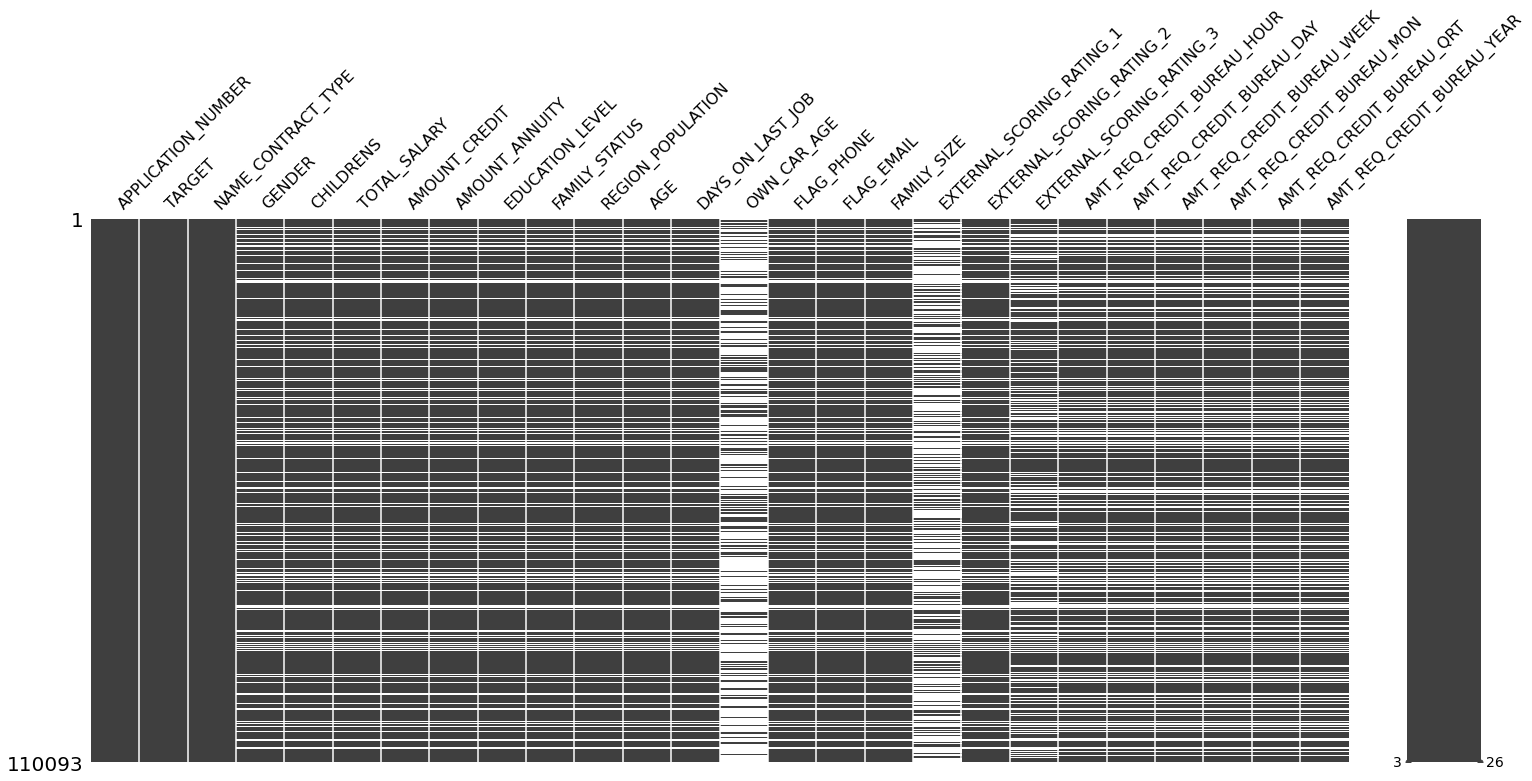

In [44]:
msno.matrix(df_train_merged)

In [45]:
df_train_merged.columns[df_train_merged.isnull().any()]

Index(['GENDER', 'CHILDRENS', 'TOTAL_SALARY', 'AMOUNT_CREDIT',
       'AMOUNT_ANNUITY', 'EDUCATION_LEVEL', 'FAMILY_STATUS',
       'REGION_POPULATION', 'AGE', 'DAYS_ON_LAST_JOB', 'OWN_CAR_AGE',
       'FLAG_PHONE', 'FLAG_EMAIL', 'FAMILY_SIZE', 'EXTERNAL_SCORING_RATING_1',
       'EXTERNAL_SCORING_RATING_2', 'EXTERNAL_SCORING_RATING_3',
       'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY',
       'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON',
       'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object')

In [46]:
df_test_merged.columns[df_test_merged.isnull().any()]


Index(['GENDER', 'CHILDRENS', 'TOTAL_SALARY', 'AMOUNT_CREDIT',
       'AMOUNT_ANNUITY', 'EDUCATION_LEVEL', 'FAMILY_STATUS',
       'REGION_POPULATION', 'AGE', 'DAYS_ON_LAST_JOB', 'OWN_CAR_AGE',
       'FLAG_PHONE', 'FLAG_EMAIL', 'FAMILY_SIZE', 'EXTERNAL_SCORING_RATING_1',
       'EXTERNAL_SCORING_RATING_2', 'EXTERNAL_SCORING_RATING_3',
       'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY',
       'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON',
       'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object')

In [47]:
def check_missings(df: pd.DataFrame) -> pd.DataFrame:
    """
    Функция для вычисления среднего и общего числа пропусков.

    Parameters
    ----------
    df: pandas.core.DataFrame
        Набор данных для вычисления статистики.

    Returns
    -------
    result: pandas.core.DataFrame
        Датафрейм со статистикой распределения пропусков.

    """
    na = df.isnull().sum()
    result = pd.DataFrame({
        "Total": na,
        "Percent": 100*na/df.shape[0],
        "Types": df.dtypes
    })
    print(f"Total NA-values = {na.sum()}")
    return result.T

In [48]:
check_missings(df_train_merged)

Total NA-values = 672481


,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE,GENDER,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,FAMILY_STATUS,...,FAMILY_SIZE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
Total,0,0,0,20554,20554,20554,20554,20559,20554,20554,...,20555,71002,20748,38285,32613,32613,32613,32613,32613,32613
Percent,0,0,0,18.6697,18.6697,18.6697,18.6697,18.6742,18.6697,18.6697,...,18.6706,64.4927,18.8459,34.7751,29.6231,29.6231,29.6231,29.6231,29.6231,29.6231
Types,int64,int64,object,object,float64,float64,float64,float64,object,object,...,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


In [49]:
check_missings(df_test_merged)

Total NA-values = 1012213


,APPLICATION_NUMBER,NAME_CONTRACT_TYPE,GENDER,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,FAMILY_STATUS,REGION_POPULATION,...,FAMILY_SIZE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
Total,0,0,30965,30965,30965,30965,30971,30965,30965,30965,...,30966,106506,31250,57641,49104,49104,49104,49104,49104,49104
Percent,0,0,18.7506,18.7506,18.7506,18.7506,18.7543,18.7506,18.7506,18.7506,...,18.7512,64.494,18.9232,34.9041,29.7346,29.7346,29.7346,29.7346,29.7346,29.7346
Types,int64,object,object,float64,float64,float64,float64,object,object,float64,...,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


In [50]:
df_train_merged["TARGET"].unique()


array([0, 1], dtype=int64)

In [51]:
df_train_merged["TARGET"].value_counts()


0    101196
1      8897
Name: TARGET, dtype: int64

Целевое значение очень мало представлено, всего 9% процентов от общего количества

In [52]:
df_train_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110093 entries, 0 to 110092
Data columns (total 26 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   APPLICATION_NUMBER          110093 non-null  int64  
 1   TARGET                      110093 non-null  int64  
 2   NAME_CONTRACT_TYPE          110093 non-null  object 
 3   GENDER                      89539 non-null   object 
 4   CHILDRENS                   89539 non-null   float64
 5   TOTAL_SALARY                89539 non-null   float64
 6   AMOUNT_CREDIT               89539 non-null   float64
 7   AMOUNT_ANNUITY              89534 non-null   float64
 8   EDUCATION_LEVEL             89539 non-null   object 
 9   FAMILY_STATUS               89539 non-null   object 
 10  REGION_POPULATION           89539 non-null   float64
 11  AGE                         89539 non-null   float64
 12  DAYS_ON_LAST_JOB            89539 non-null   float64
 13  OWN_CAR_AGE   

In [53]:
df_test_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 165141 entries, 0 to 165140
Data columns (total 25 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   APPLICATION_NUMBER          165141 non-null  int64  
 1   NAME_CONTRACT_TYPE          165141 non-null  object 
 2   GENDER                      134176 non-null  object 
 3   CHILDRENS                   134176 non-null  float64
 4   TOTAL_SALARY                134176 non-null  float64
 5   AMOUNT_CREDIT               134176 non-null  float64
 6   AMOUNT_ANNUITY              134170 non-null  float64
 7   EDUCATION_LEVEL             134176 non-null  object 
 8   FAMILY_STATUS               134176 non-null  object 
 9   REGION_POPULATION           134176 non-null  float64
 10  AGE                         134176 non-null  float64
 11  DAYS_ON_LAST_JOB            134176 non-null  float64
 12  OWN_CAR_AGE                 45501 non-null   float64
 13  FLAG_PHONE    

Text(0, 0.5, 'count')

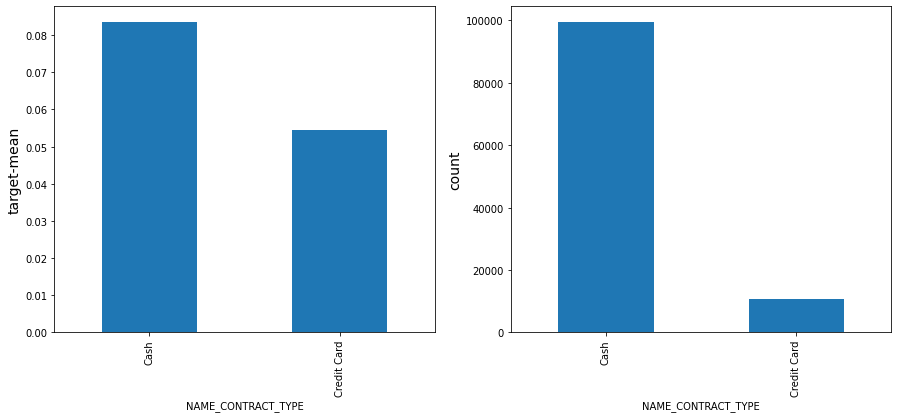

In [54]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
df_train_merged.groupby(["NAME_CONTRACT_TYPE"])["TARGET"].mean().plot(kind="bar", ax=axes[0])
df_train_merged.groupby(["NAME_CONTRACT_TYPE"])["TARGET"].size().plot(kind="bar", ax=axes[1])
axes[0].set_ylabel("target-mean", fontsize=14)
axes[1].set_ylabel("count", fontsize=14)

видим, что тип кредита cradit card имеет большую значимость, т.к. при меньшем количестве в среднем не сильно уступает наличным.

Text(0, 0.5, 'count')

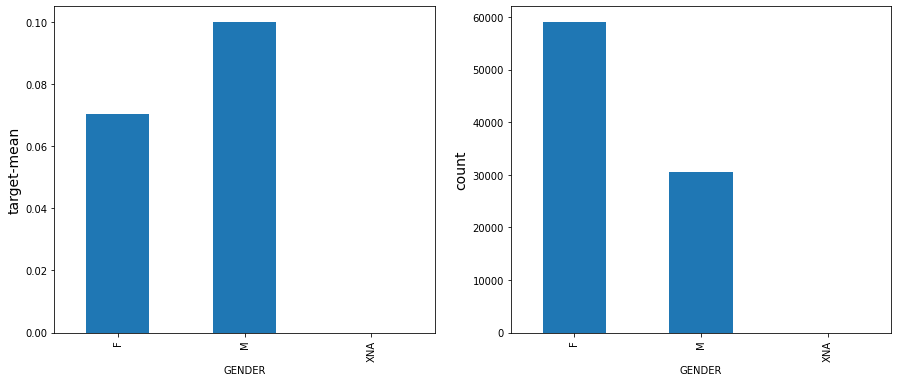

In [55]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
df_train_merged.groupby(["GENDER"])["TARGET"].mean().plot(kind="bar", ax=axes[0])
df_train_merged.groupby(["GENDER"])["TARGET"].size().plot(kind="bar", ax=axes[1])
axes[0].set_ylabel("target-mean", fontsize=14)
axes[1].set_ylabel("count", fontsize=14)

In [56]:
#в данных по полу есть третья графа, пустая. используем ее для пропусков
df_train_merged['GENDER'].fillna('XNA', inplace=True)


Text(0, 0.5, 'count')

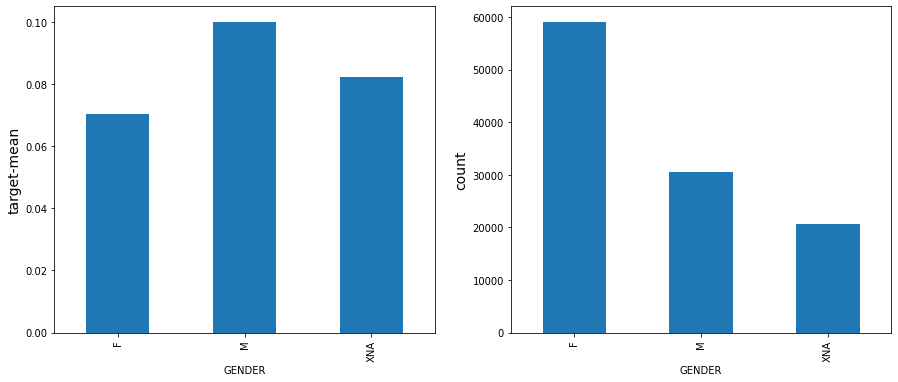

In [57]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
df_train_merged.groupby(["GENDER"])["TARGET"].mean().plot(kind="bar", ax=axes[0])
df_train_merged.groupby(["GENDER"])["TARGET"].size().plot(kind="bar", ax=axes[1])
axes[0].set_ylabel("target-mean", fontsize=14)
axes[1].set_ylabel("count", fontsize=14)

мужчин меньше, но они сильнее связаны с целевой переменной. При этом, мы видим, что количество пропусков также сильно связано с целевой переменной. Это означает, что либо это мужчины, либо в пропуски попали все связанные с целевым значением женщины

Text(0, 0.5, 'count')

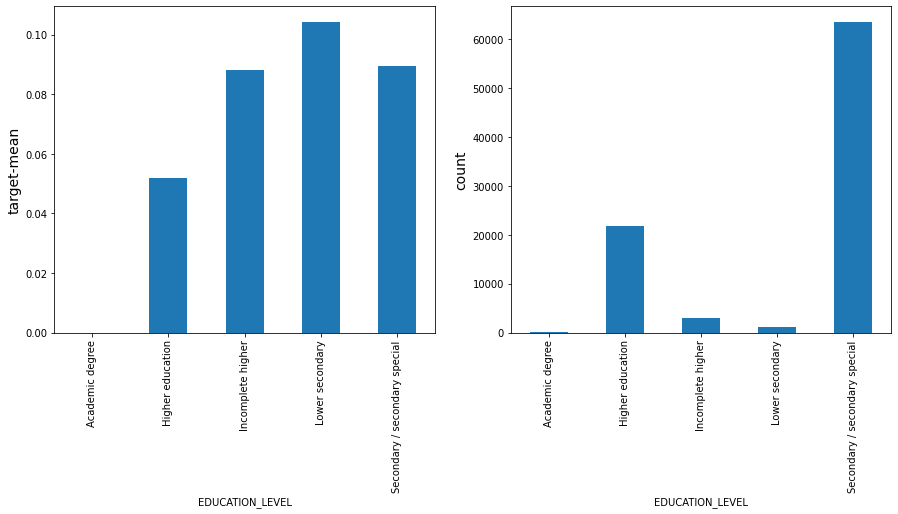

In [58]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
df_train_merged.groupby(["EDUCATION_LEVEL"])["TARGET"].mean().plot(kind="bar", ax=axes[0])
df_train_merged.groupby(["EDUCATION_LEVEL"])["TARGET"].size().plot(kind="bar", ax=axes[1])
axes[0].set_ylabel("target-mean", fontsize=14)
axes[1].set_ylabel("count", fontsize=14)


lower secondary и incomplete higher сильно выбиваются.

Text(0, 0.5, 'count')

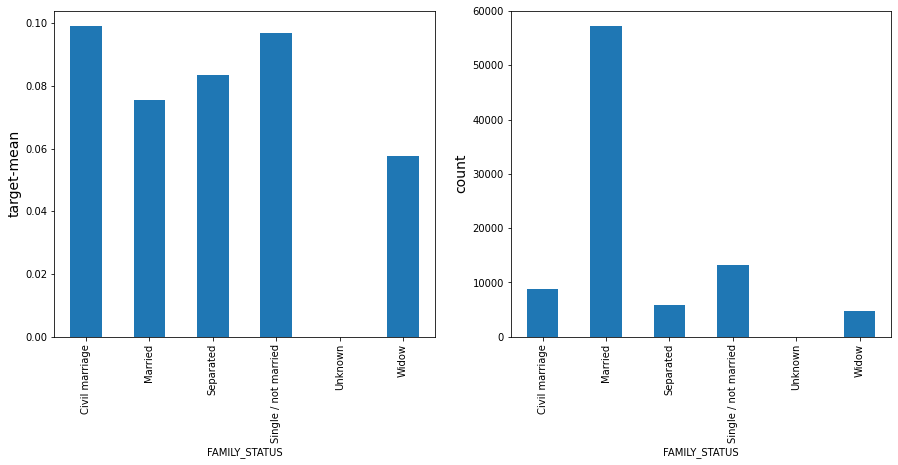

In [59]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
df_train_merged.groupby(["FAMILY_STATUS"])["TARGET"].mean().plot(kind="bar", ax=axes[0])
df_train_merged.groupby(["FAMILY_STATUS"])["TARGET"].size().plot(kind="bar", ax=axes[1])
axes[0].set_ylabel("target-mean", fontsize=14)
axes[1].set_ylabel("count", fontsize=14)


In [60]:
class MissingImputer():
    """Заполнение пропусков"""
    
    def __init__(self):
        self.medians=None
        self.mins = None

    def fit(self, df):
        self.medians = df.median()
    
    def transform(self, df):
        #Обработка количественных признаков 
        df['FAMILY_STATUS'].fillna('Unknown', inplace=True)
        
        numerical_features = df.select_dtypes(include=[np.number])
        
        cat_features = df.select_dtypes(include = ['object'])

        for num in numerical_features:
            numerical_features.loc[(numerical_features[num].isnull(), [num])] = numerical_features[num].median()

        for cat in cat_features:
            cat_features.loc[(cat_features[cat].isnull(), [cat])] = df[cat].mode()[0]
                        
        #for cat in cat_features:
            #enc = LabelEncoder()
            #cat_features[cat] = enc.fit_transform(cat_features[cat])
        #   cat_features = pd.concat([cat_features, pd.get_dummies(cat_features[cat], prefix=cat)], axis=1)
            
        #cat_features = cat_features.drop(['NAME_CONTRACT_TYPE', 'GENDER', 'EDUCATION_LEVEL', 'FAMILY_STATUS'], axis=1)
        df = pd.concat([numerical_features, cat_features], axis=1)
        
        return df

In [61]:
imputer = MissingImputer()

imputer.fit(df_train_merged)

df_train_merged = imputer.transform(df_train_merged)
df_test_merged = imputer.transform(df_test_merged)

In [62]:
df_train_merged.columns


Index(['APPLICATION_NUMBER', 'TARGET', 'CHILDRENS', 'TOTAL_SALARY',
       'AMOUNT_CREDIT', 'AMOUNT_ANNUITY', 'REGION_POPULATION', 'AGE',
       'DAYS_ON_LAST_JOB', 'OWN_CAR_AGE', 'FLAG_PHONE', 'FLAG_EMAIL',
       'FAMILY_SIZE', 'EXTERNAL_SCORING_RATING_1', 'EXTERNAL_SCORING_RATING_2',
       'EXTERNAL_SCORING_RATING_3', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR', 'NAME_CONTRACT_TYPE', 'GENDER',
       'EDUCATION_LEVEL', 'FAMILY_STATUS'],
      dtype='object')

In [68]:
class FeatureImputer():
    """Заполнение пропусков"""
    
    def __init__(self):
        self.medians=None
        self.mins = None

    def fit(self, df):
        self.medians = df.median()
    
    def transform(self, df):
        #Обработка количественных признаков 
        
        numerical_features = df.select_dtypes(include=[np.number])
        
        cat_features = df.select_dtypes(include = ['object'])

        for num in numerical_features:
            numerical_features.loc[(numerical_features[num].isnull(), [num])] = numerical_features[num].median()

        for cat in cat_features:
            cat_features.loc[(cat_features[cat].isnull(), [cat])] = df[cat].mode()[0]
                        
        for cat in cat_features:
            #enc = LabelEncoder()
            #cat_features[cat] = enc.fit_transform(cat_features[cat])
            cat_features = pd.concat([cat_features, pd.get_dummies(cat_features[cat], prefix=cat)], axis=1)
            
        #cat_features = cat_features.drop(['NAME_CONTRACT_TYPE', 'GENDER', 'EDUCATION_LEVEL', 'FAMILY_STATUS'], axis=1)
        df = pd.concat([numerical_features, cat_features], axis=1)
        
        df["DAYS_ON_LAST_JOB"] = df["DAYS_ON_LAST_JOB"].replace(365243, np.nan)
        bki_flags = [flag for flag in df.columns if "AMT_REQ_CREDIT_BUREAU" in flag]
        df["bki_requests_count"] = df[bki_flags].sum(axis=1)
        df["bki_kurtosis"] = df[bki_flags].kurtosis(axis=1)

        df["external_scoring_prod"] = df["EXTERNAL_SCORING_RATING_1"] * df["EXTERNAL_SCORING_RATING_2"] * df["EXTERNAL_SCORING_RATING_3"]
        df["external_scoring_weighted"] = df.EXTERNAL_SCORING_RATING_1 * 2 + df.EXTERNAL_SCORING_RATING_2 * 1 + df.EXTERNAL_SCORING_RATING_3 * 3

        for function_name in ["min", "max", "mean", "nanmedian", "var"]:
            feature_name = "EXTERNAL_SCORING_RATING_{}".format(function_name)
            df[feature_name] = eval("np.{}".format(function_name))(
                df[["EXTERNAL_SCORING_RATING_1", "EXTERNAL_SCORING_RATING_2", "EXTERNAL_SCORING_RATING_3"]], axis=1
            )

        # Отношение между основными фин. показателями
        df['ratio_credit_to_annuity'] = df['AMOUNT_CREDIT'] / df['AMOUNT_ANNUITY']
        df["ratio_annuity_to_salary"] = df['AMOUNT_ANNUITY'] / df['TOTAL_SALARY']
        df['ratio_credit_to_salary'] = df['AMOUNT_CREDIT'] / df['TOTAL_SALARY']
        df['ratio_salary_to_annuity'] = df['TOTAL_SALARY'] / df['AMOUNT_ANNUITY']

        
        # Отношение фин. показателей к возрасту и временным фичам
        df["ratio_annuity_to_age"] = df["AMOUNT_ANNUITY"] / df["AGE"]
        df["ratio_credit_to_age"] = df["AMOUNT_CREDIT"] / df["AGE"]
        df["ratio_salary_to_age"] = df["TOTAL_SALARY"] / df["AGE"]
        df["ratio_salary_to_experience"] = df["TOTAL_SALARY"] / df["DAYS_ON_LAST_JOB"]
        df["ratio_credit_to_experience"] = df["AMOUNT_CREDIT"] / df["DAYS_ON_LAST_JOB"]
        df["ratio_annuity_to_experience"] = df["AMOUNT_ANNUITY"] / df["DAYS_ON_LAST_JOB"]
        df['ratio_salary_to_family'] = df['TOTAL_SALARY'] / df['FAMILY_SIZE']


        # Отношение врменных признаков
        df["ratio_age_to_experience"] = df["AGE"] / df["DAYS_ON_LAST_JOB"]
        df["ratio_salary_to_region_population"] = df["TOTAL_SALARY"] * df["REGION_POPULATION"]
        df["ratio_car_to_experience"] = df["OWN_CAR_AGE"] / df["DAYS_ON_LAST_JOB"]
        df["ratio_car_to_age"] = df["OWN_CAR_AGE"] / df["AGE"]

        # Произведение фин. показателей кредита на вероятность дефолта
        # Такая штука называется математическим ожиданием дефолта или ожидаемыми потерями
        df["expected_total_loss_1"] = df["EXTERNAL_SCORING_RATING_1"] * df["AMOUNT_CREDIT"]
        df["expected_total_loss_2"] = df["EXTERNAL_SCORING_RATING_2"] * df["AMOUNT_CREDIT"]
        df["expected_total_loss_3"] = df["EXTERNAL_SCORING_RATING_3"] * df["AMOUNT_CREDIT"]
        df["expected_monthly_loss_1"] = df["EXTERNAL_SCORING_RATING_1"] * df["AMOUNT_ANNUITY"]
        df["expected_monthly_loss_2"] = df["EXTERNAL_SCORING_RATING_2"] * df["AMOUNT_ANNUITY"]
        df["expected_monthly_loss_3"] = df["EXTERNAL_SCORING_RATING_3"] * df["AMOUNT_ANNUITY"]
        
        pca = PCA(n_components=1)
        N_1 = pca.fit_transform(df.loc[:,['EXTERNAL_SCORING_RATING_1', 'EXTERNAL_SCORING_RATING_2', "EXTERNAL_SCORING_RATING_3"]].values)
        pca.explained_variance_ratio_[:2].sum()

        df['N_1'] = N_1
        N_1 = pca.transform(df.loc[:,['EXTERNAL_SCORING_RATING_1', 'EXTERNAL_SCORING_RATING_2', "EXTERNAL_SCORING_RATING_3"]].values)


        pca = PCA(n_components=1)
        N_2 = pca.fit_transform(df.loc[:,['AMOUNT_ANNUITY', 'AMOUNT_CREDIT']].values)
        pca.explained_variance_ratio_[:2].sum()  

        df['N_2'] = N_2

        N_2 = pca.transform(df.loc[:,['AMOUNT_ANNUITY', 'AMOUNT_CREDIT']].values)

        #pca = PCA(n_components=1)
        #N_3 = pca.fit_transform(df.loc[:,['DAYS_ON_LAST_JOB', 'AGE']].values)
        #pca.explained_variance_ratio_[:2].sum() 

        #df['N_3'] = N_3
        #N_3 = pca.transform(df.loc[:,['DAYS_ON_LAST_JOB', 'AGE']].values)        
        return df

In [69]:
df_train_merged['Credit_card_man_XNA'] = 0
df_train_merged.loc[(df_train_merged['NAME_CONTRACT_TYPE'] == 'Credit Card') | (df_train_merged['GENDER'] != 'F'), 'Credit_card_man_XNA'] = 1
                
df_train_merged['Credit_card_education'] = 0
df_train_merged.loc[(df_train_merged['NAME_CONTRACT_TYPE'] == 'Credit Card') | (df_train_merged['EDUCATION_LEVEL'] == 'Lower secondary'), 'Credit_card_education'] = 1
df_train_merged.loc[(df_train_merged['NAME_CONTRACT_TYPE'] == 'Credit Card') | (df_train_merged['EDUCATION_LEVEL'] == 'Incomplete higher'), 'Credit_card_education'] = 1
                
df_train_merged['Credit_card_marital'] = 1
df_train_merged.loc[(df_train_merged['NAME_CONTRACT_TYPE'] == 'Cash') | (df_train_merged['FAMILY_STATUS'] == 'Married'), 'Credit_card_marital'] = 0

In [70]:
df_test_merged['Credit_card_man_XNA'] = 0
df_test_merged.loc[(df_test_merged['NAME_CONTRACT_TYPE'] == 'Credit Card') | (df_test_merged['GENDER'] != 'F'), 'Credit_card_man_XNA'] = 1
                
df_test_merged['Credit_card_education'] = 0
df_test_merged.loc[(df_test_merged['NAME_CONTRACT_TYPE'] == 'Credit Card') | (df_test_merged['EDUCATION_LEVEL'] == 'Lower secondary'), 'Credit_card_education'] = 1
df_test_merged.loc[(df_test_merged['NAME_CONTRACT_TYPE'] == 'Credit Card') | (df_test_merged['EDUCATION_LEVEL'] == 'Incomplete higher'), 'Credit_card_education'] = 1
                
df_test_merged['Credit_card_marital'] = 1
df_test_merged.loc[(df_test_merged['NAME_CONTRACT_TYPE'] == 'Cash') | (df_test_merged['FAMILY_STATUS'] == 'Married'), 'Credit_card_marital'] = 0

In [72]:
imputer = FeatureImputer()

imputer.fit(df_train_merged)

df_train_merged = imputer.transform(df_train_merged)
df_test_merged = imputer.transform(df_test_merged)

In [73]:
df_train_merged.columns

Index(['APPLICATION_NUMBER', 'TARGET', 'CHILDRENS', 'TOTAL_SALARY',
       'AMOUNT_CREDIT', 'AMOUNT_ANNUITY', 'REGION_POPULATION', 'AGE',
       'DAYS_ON_LAST_JOB', 'OWN_CAR_AGE', 'FLAG_PHONE', 'FLAG_EMAIL',
       'FAMILY_SIZE', 'EXTERNAL_SCORING_RATING_1', 'EXTERNAL_SCORING_RATING_2',
       'EXTERNAL_SCORING_RATING_3', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR', 'Credit_card_man_XNA',
       'Credit_card_education', 'Credit_card_marital', 'NAME_CONTRACT_TYPE',
       'GENDER', 'EDUCATION_LEVEL', 'FAMILY_STATUS', 'NAME_CONTRACT_TYPE_Cash',
       'NAME_CONTRACT_TYPE_Credit Card', 'GENDER_F', 'GENDER_M', 'GENDER_XNA',
       'EDUCATION_LEVEL_Academic degree', 'EDUCATION_LEVEL_Higher education',
       'EDUCATION_LEVEL_Incomplete higher', 'EDUCATION_LEVEL_Lower secondary',
       'EDUCATION_LEVEL_Secondary / secondary special',
      

In [74]:
df_train_merged = df_train_merged.drop(['NAME_CONTRACT_TYPE', 'GENDER', 'EDUCATION_LEVEL', 'FAMILY_STATUS'], axis=1)
df_test_merged = df_test_merged.drop(['NAME_CONTRACT_TYPE', 'GENDER', 'EDUCATION_LEVEL', 'FAMILY_STATUS'], axis=1)

In [75]:
def plot_features_distribution(train: pd.DataFrame, test: pd.DataFrame, features):
    """
    Построение графика распределения признака на обучающем и тестовом наборе данных.

    Parameters
    ----------
    train: pandas.core.frame.DataFrame
        Обучающая выборка.

    test: pandas.core.frame.DataFrame
        Тестовая выборка.

    features: List[str]
        Список с названеим признаков.

    """
    n_rows, n_cols = len(features)//5, 5
    if len(features) % 5:
        n_rows += 1

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(10*n_rows, 10*n_cols))
    for num, feature in enumerate(features, start=1):
        plt.subplot(n_rows, n_cols, num)
        statistic, pvalue = ks_2samp(train[feature].sample(5000), test[feature].sample(5000))
        plt.title(f"{feature}, p-value = {round(pvalue, 4)}", size=14)
        sns.distplot(train[feature], hist=False, color="#33137d")
        sns.distplot(test[feature], color="#007539", hist=False)


In [76]:
target = df_train_merged["TARGET"]
#df_train_merged = df_train_merged.drop(["TARGET"], axis=1)

In [77]:
numerical_features = df_train_merged.select_dtypes(include=[np.number])
numerical_features
features = numerical_features.columns.tolist()


In [78]:
features

['APPLICATION_NUMBER',
 'TARGET',
 'CHILDRENS',
 'TOTAL_SALARY',
 'AMOUNT_CREDIT',
 'AMOUNT_ANNUITY',
 'REGION_POPULATION',
 'AGE',
 'DAYS_ON_LAST_JOB',
 'OWN_CAR_AGE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'FAMILY_SIZE',
 'EXTERNAL_SCORING_RATING_1',
 'EXTERNAL_SCORING_RATING_2',
 'EXTERNAL_SCORING_RATING_3',
 'AMT_REQ_CREDIT_BUREAU_HOUR',
 'AMT_REQ_CREDIT_BUREAU_DAY',
 'AMT_REQ_CREDIT_BUREAU_WEEK',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'Credit_card_man_XNA',
 'Credit_card_education',
 'Credit_card_marital',
 'NAME_CONTRACT_TYPE_Cash',
 'NAME_CONTRACT_TYPE_Credit Card',
 'GENDER_F',
 'GENDER_M',
 'GENDER_XNA',
 'EDUCATION_LEVEL_Academic degree',
 'EDUCATION_LEVEL_Higher education',
 'EDUCATION_LEVEL_Incomplete higher',
 'EDUCATION_LEVEL_Lower secondary',
 'EDUCATION_LEVEL_Secondary / secondary special',
 'FAMILY_STATUS_Civil marriage',
 'FAMILY_STATUS_Married',
 'FAMILY_STATUS_Separated',
 'FAMILY_STATUS_Single / not married',
 'FAMILY_ST

In [79]:
#plot_features_distribution(df_train_merged, df_test_merged, features=features)

In [80]:
df_train_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110093 entries, 0 to 110092
Data columns (total 73 columns):
 #   Column                                         Non-Null Count   Dtype  
---  ------                                         --------------   -----  
 0   APPLICATION_NUMBER                             110093 non-null  int64  
 1   TARGET                                         110093 non-null  int64  
 2   CHILDRENS                                      110093 non-null  float64
 3   TOTAL_SALARY                                   110093 non-null  float64
 4   AMOUNT_CREDIT                                  110093 non-null  float64
 5   AMOUNT_ANNUITY                                 110093 non-null  float64
 6   REGION_POPULATION                              110093 non-null  float64
 7   AGE                                            110093 non-null  float64
 8   DAYS_ON_LAST_JOB                               94084 non-null   float64
 9   OWN_CAR_AGE                          

In [81]:
#fig, axes = plt.subplots(17, 4, figsize=(50, 50))

#for num, feature in enumerate(features):
#    sns.kdeplot(df_train_merged.loc[target==1, feature], ax=axes[num//4, num%4], color="blue", label="target=1")
#    sns.kdeplot(df_train_merged.loc[target==0, feature], ax=axes[num//4, num%4], color="red", label="target=0")
#    sns.kdeplot(df_train_merged[feature], ax=axes[num//4, num%4], color="green", label="train")
#    axes[num//4, num%4].set_title(feature, fontsize=14)
 #plt.show()

In [82]:
correlation = df_train_merged.corr()
corr_with_target = correlation["TARGET"].sort_values(ascending = False)
corr_with_target

TARGET                                           1.000000
N_1                                              0.186778
EXTERNAL_SCORING_RATING_var                      0.061397
EDUCATION_LEVEL_Secondary / secondary special    0.045948
GENDER_M                                         0.043532
                                                   ...   
EXTERNAL_SCORING_RATING_min                     -0.162035
external_scoring_prod                           -0.170404
EXTERNAL_SCORING_RATING_nanmedian               -0.173989
external_scoring_weighted                       -0.187810
EXTERNAL_SCORING_RATING_mean                    -0.199136
Name: TARGET, Length: 73, dtype: float64

In [83]:
def lightgbm_cross_validation(params, X, y, cv, categorical = None):
    """
    Кросс-валидация для модели catbooost.

    Parameters
    ----------
    params: dict
        Словарь гиперпараметров модели.

    X: pandas.core.frame.DataFrame
        Матрица признако для обучения модели.

    y: pandas.core.frame.Series
        Вектор целевой переменной для обучения модели.

    cv: KFold or StratifiedKFold generator.
        Объект KFold / StratifiedKFold для определения
        стратегии кросс-валидации модели.

    categorical: str, optional, default = None
        Список категориальных признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    estimators: list
        Список с объектами обученной модели.

    oof_preds: np.array
        Вектор OOF-прогнозов.

    """
    if not categorical:
        categorical = "auto"

    estimators, folds_scores = [], []
    oof_preds = np.zeros(X.shape[0])
    print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")

    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):
        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]

        model = lgb.LGBMClassifier(**params)
        model.fit(
            x_train, y_train,
            eval_set=[(x_valid, y_valid)],
            eval_metric="auc", verbose=50, early_stopping_rounds=500,
            categorical_feature=categorical
        )
        oof_preds[valid_idx] = model.predict_proba(x_valid)[:, 1]
        score = roc_auc_score(y_valid, oof_preds[valid_idx])
        print(f"Fold {fold+1}, Valid score = {round(score, 5)}")
        folds_scores.append(round(score, 5))
        estimators.append(model)

    print(f"Score by each fold: {folds_scores}")
    print("="*65)
    return estimators, oof_preds



In [84]:
lgbm_params = {
    'boosting_type': 'gbdt',
    'n_estimators': 10000,
    'learning_rate': 0.005134,
    'num_leaves': 54,
    'max_depth': 10,
    'subsample_for_bin': 240000,
    'reg_alpha': 0.436193,
    'reg_lambda': 0.479169,
    'colsample_bytree': 0.508716,
    'min_split_gain': 0.024766,
    'subsample': 0.7,
    'is_unbalance': False,
    'random_state': 42,
    'silent': -1,
    'verbose': -1
}

cv = KFold(n_splits=7, random_state=435, shuffle=True)
target, df_train_merged = df_train_merged["TARGET"], df_train_merged.drop(["TARGET"], axis=1)

In [85]:
estimators, oof_preds_lgbm = lightgbm_cross_validation(
    lgbm_params, df_train_merged, target, cv
)

Tue Dec 22 20:46:11 2020, Cross-Validation, 110093 rows, 72 cols
Training until validation scores don't improve for 500 rounds
[50]	valid_0's auc: 0.726381	valid_0's binary_logloss: 0.270332
[100]	valid_0's auc: 0.726563	valid_0's binary_logloss: 0.264355
[150]	valid_0's auc: 0.727563	valid_0's binary_logloss: 0.260552
[200]	valid_0's auc: 0.728636	valid_0's binary_logloss: 0.258032
[250]	valid_0's auc: 0.72973	valid_0's binary_logloss: 0.256169
[300]	valid_0's auc: 0.730316	valid_0's binary_logloss: 0.254896
[350]	valid_0's auc: 0.732073	valid_0's binary_logloss: 0.253936
[400]	valid_0's auc: 0.733158	valid_0's binary_logloss: 0.25317
[450]	valid_0's auc: 0.734384	valid_0's binary_logloss: 0.252506
[500]	valid_0's auc: 0.735256	valid_0's binary_logloss: 0.25195
[550]	valid_0's auc: 0.736088	valid_0's binary_logloss: 0.251462
[600]	valid_0's auc: 0.737175	valid_0's binary_logloss: 0.250992
[650]	valid_0's auc: 0.737862	valid_0's binary_logloss: 0.250648
[700]	valid_0's auc: 0.73893	val

[1100]	valid_0's auc: 0.731605	valid_0's binary_logloss: 0.258078
[1150]	valid_0's auc: 0.731608	valid_0's binary_logloss: 0.258058
[1200]	valid_0's auc: 0.73181	valid_0's binary_logloss: 0.258022
[1250]	valid_0's auc: 0.731665	valid_0's binary_logloss: 0.258003
[1300]	valid_0's auc: 0.731484	valid_0's binary_logloss: 0.25801
[1350]	valid_0's auc: 0.731288	valid_0's binary_logloss: 0.25805
[1400]	valid_0's auc: 0.731468	valid_0's binary_logloss: 0.258043
[1450]	valid_0's auc: 0.731836	valid_0's binary_logloss: 0.258048
[1500]	valid_0's auc: 0.731796	valid_0's binary_logloss: 0.258073
[1550]	valid_0's auc: 0.731614	valid_0's binary_logloss: 0.258082
[1600]	valid_0's auc: 0.732209	valid_0's binary_logloss: 0.258108
[1650]	valid_0's auc: 0.732062	valid_0's binary_logloss: 0.258095
[1700]	valid_0's auc: 0.732045	valid_0's binary_logloss: 0.258113
Early stopping, best iteration is:
[1235]	valid_0's auc: 0.731924	valid_0's binary_logloss: 0.257986
Fold 3, Valid score = 0.73192
Training until

[1050]	valid_0's auc: 0.71209	valid_0's binary_logloss: 0.257448
[1100]	valid_0's auc: 0.712447	valid_0's binary_logloss: 0.257422
[1150]	valid_0's auc: 0.712494	valid_0's binary_logloss: 0.257406
[1200]	valid_0's auc: 0.712825	valid_0's binary_logloss: 0.257352
[1250]	valid_0's auc: 0.713252	valid_0's binary_logloss: 0.257328
[1300]	valid_0's auc: 0.713618	valid_0's binary_logloss: 0.257315
[1350]	valid_0's auc: 0.713857	valid_0's binary_logloss: 0.25729
[1400]	valid_0's auc: 0.714219	valid_0's binary_logloss: 0.257281
[1450]	valid_0's auc: 0.714047	valid_0's binary_logloss: 0.257269
[1500]	valid_0's auc: 0.714175	valid_0's binary_logloss: 0.257243
[1550]	valid_0's auc: 0.714315	valid_0's binary_logloss: 0.25723
[1600]	valid_0's auc: 0.714446	valid_0's binary_logloss: 0.257247
[1650]	valid_0's auc: 0.714433	valid_0's binary_logloss: 0.257252
[1700]	valid_0's auc: 0.714415	valid_0's binary_logloss: 0.257281
[1750]	valid_0's auc: 0.714524	valid_0's binary_logloss: 0.257295
[1800]	valid_

In [86]:
score = roc_auc_score(target, oof_preds_lgbm)
print(f"Score = {round(score, 4)}")

Score = 0.7282


In [87]:
categorial = df_train_merged.dtypes[df_train_merged.dtypes == "object"].index
numerical = list(set(df_train_merged.columns) - set(categorial))

y_pred1 = np.zeros(df_test_merged.shape[0])
df_test_merged[numerical] = df_test_merged[numerical].astype(float)
df_test_merged[categorial] = df_test_merged[categorial].astype(str)

for estimator in estimators:
    y_pred1 += estimator.predict_proba(df_test_merged)[:, 1]


In [88]:
test_id = df_test["APPLICATION_NUMBER"]

y_pred1 = pd.DataFrame({
    "APPLICATION_NUMBER": test_id,
    "TARGET": y_pred1 / cv.n_splits
})

In [89]:
x_train, x_valid = train_test_split(
    df_train_merged.drop(["APPLICATION_NUMBER"], axis=1), train_size=0.7, random_state=1
)
y_train, y_valid = train_test_split(
    target, train_size=0.7, random_state=1
)

In [90]:
params = {
    'boosting_type': 'gbdt',
    'n_estimators': 10000,
    'learning_rate': 0.005134,
    'num_leaves': 54,
    'max_depth': 10,
    'subsample_for_bin': 240000,
    'reg_alpha': 0.436193,
    'reg_lambda': 0.479169,
    'colsample_bytree': 0.508716,
    'min_split_gain': 0.024766,
    'subsample': 0.7,
    'is_unbalance': False,
    'random_state': 42,
    'silent': -1,
    'verbose': -1
}
model = lgb.LGBMClassifier(**params)
model.fit(
        x_train, y_train,
        eval_set=[(x_valid, y_valid)],
        eval_metric="auc", verbose=50, early_stopping_rounds=500
        )

Training until validation scores don't improve for 500 rounds
[50]	valid_0's auc: 0.713768	valid_0's binary_logloss: 0.27351
[100]	valid_0's auc: 0.715329	valid_0's binary_logloss: 0.267941
[150]	valid_0's auc: 0.715602	valid_0's binary_logloss: 0.264473
[200]	valid_0's auc: 0.716773	valid_0's binary_logloss: 0.262236
[250]	valid_0's auc: 0.718266	valid_0's binary_logloss: 0.260717
[300]	valid_0's auc: 0.719682	valid_0's binary_logloss: 0.259616
[350]	valid_0's auc: 0.720246	valid_0's binary_logloss: 0.258869
[400]	valid_0's auc: 0.721081	valid_0's binary_logloss: 0.25831
[450]	valid_0's auc: 0.721872	valid_0's binary_logloss: 0.257865
[500]	valid_0's auc: 0.722481	valid_0's binary_logloss: 0.257454
[550]	valid_0's auc: 0.72307	valid_0's binary_logloss: 0.257136
[600]	valid_0's auc: 0.723567	valid_0's binary_logloss: 0.256887
[650]	valid_0's auc: 0.723992	valid_0's binary_logloss: 0.256677
[700]	valid_0's auc: 0.724936	valid_0's binary_logloss: 0.256465
[750]	valid_0's auc: 0.725693	va

LGBMClassifier(colsample_bytree=0.508716, is_unbalance=False,
               learning_rate=0.005134, max_depth=10, min_split_gain=0.024766,
               n_estimators=10000, num_leaves=54, random_state=42,
               reg_alpha=0.436193, reg_lambda=0.479169, silent=-1,
               subsample=0.7, subsample_for_bin=240000, verbose=-1)

In [91]:
from copy import deepcopy

lgb_params = deepcopy(params)
lgb_params["n_estimators"] = 100

model = lgb.LGBMClassifier(**params)
model.fit(x_train, y_train)

LGBMClassifier(colsample_bytree=0.508716, is_unbalance=False,
               learning_rate=0.005134, max_depth=10, min_split_gain=0.024766,
               n_estimators=10000, num_leaves=54, random_state=42,
               reg_alpha=0.436193, reg_lambda=0.479169, silent=-1,
               subsample=0.7, subsample_for_bin=240000, verbose=-1)

In [92]:
y_score = model.predict_proba(x_valid)[:, 1]
score = roc_auc_score(y_valid, y_score)

print(f"Valid score = {round(score, 4)}")

Valid score = 0.7144


In [93]:
x_valid_, y_valid_ = x_valid.sample(5000), y_valid.sample(5000)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_valid_, y_valid_)


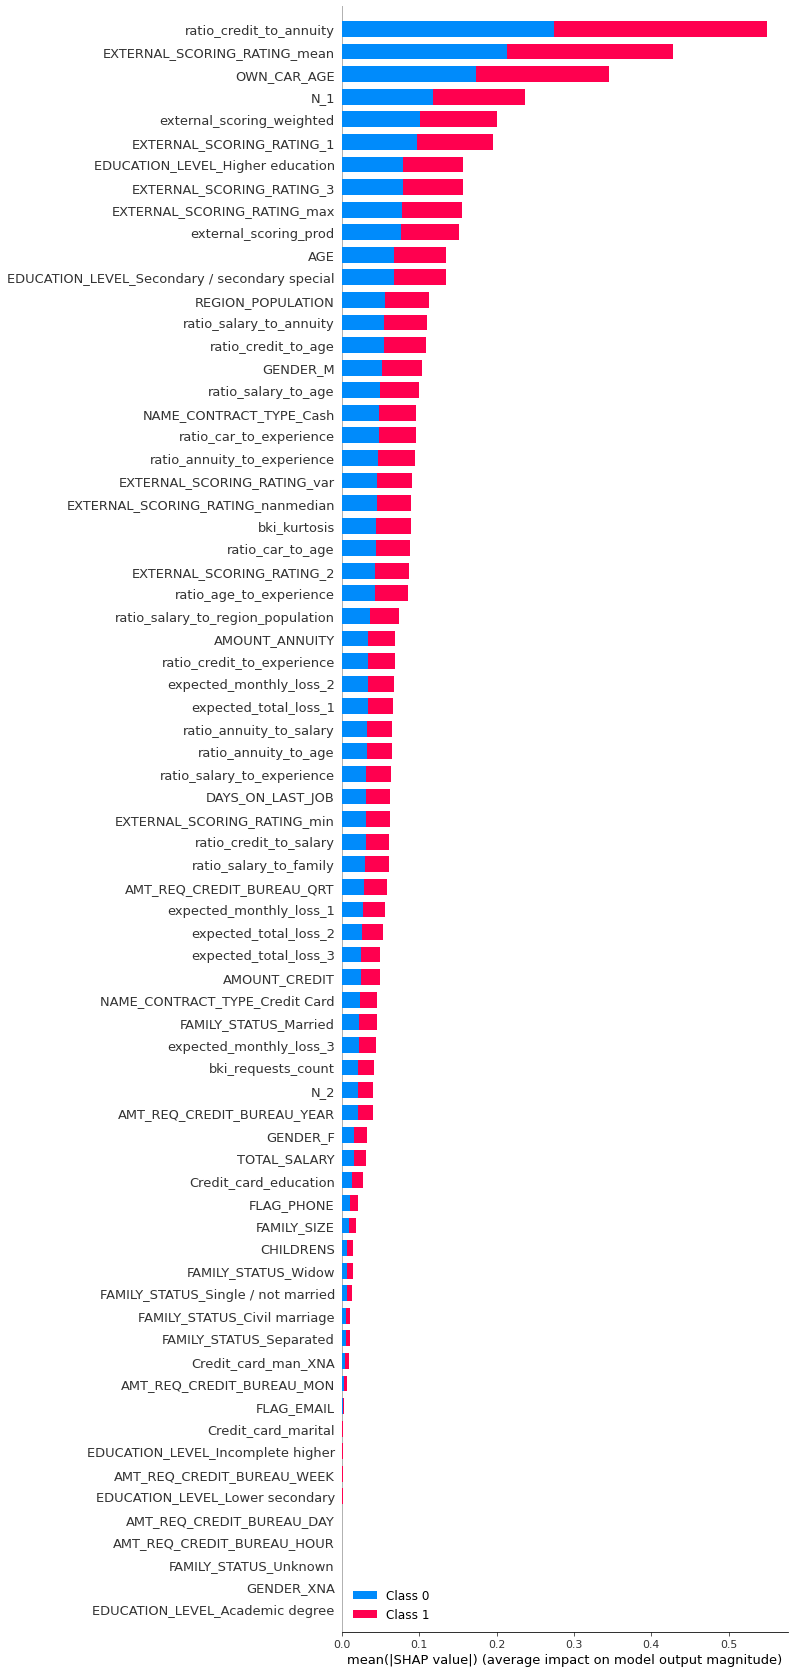

In [94]:
shap.summary_plot(shap_values, x_valid, plot_type="bar", max_display=x_valid.shape[1])

In [95]:
df_train_merged.columns


Index(['APPLICATION_NUMBER', 'CHILDRENS', 'TOTAL_SALARY', 'AMOUNT_CREDIT',
       'AMOUNT_ANNUITY', 'REGION_POPULATION', 'AGE', 'DAYS_ON_LAST_JOB',
       'OWN_CAR_AGE', 'FLAG_PHONE', 'FLAG_EMAIL', 'FAMILY_SIZE',
       'EXTERNAL_SCORING_RATING_1', 'EXTERNAL_SCORING_RATING_2',
       'EXTERNAL_SCORING_RATING_3', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR', 'Credit_card_man_XNA',
       'Credit_card_education', 'Credit_card_marital',
       'NAME_CONTRACT_TYPE_Cash', 'NAME_CONTRACT_TYPE_Credit Card', 'GENDER_F',
       'GENDER_M', 'GENDER_XNA', 'EDUCATION_LEVEL_Academic degree',
       'EDUCATION_LEVEL_Higher education', 'EDUCATION_LEVEL_Incomplete higher',
       'EDUCATION_LEVEL_Lower secondary',
       'EDUCATION_LEVEL_Secondary / secondary special',
       'FAMILY_STATUS_Civil marriage', 'FAMILY_STATUS_Married',
       'FAMILY_STATU

In [107]:
to_drop2 = ['EDUCATION_LEVEL_Academic degree', 'GENDER_XNA', 'FAMILY_STATUS_Unknown', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON', 'EDUCATION_LEVEL_Incomplete higher', 'FLAG_PHONE', 'FLAG_EMAIL', 'Credit_card_marital', 'Credit_card_man_XNA', 'FAMILY_STATUS_Civil marriage', 'FAMILY_STATUS_Separated', 'FAMILY_STATUS_Single / not married', 'FAMILY_STATUS_Widow', 'CHILDRENS', 'FAMILY_SIZE', 'Credit_card_education', 'TOTAL_SALARY', 'GENDER_F', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'N_2', 'bki_requests_count', 'expected_monthly_loss_3', 'FAMILY_STATUS_Married', 'NAME_CONTRACT_TYPE_Credit Card', 'AMOUNT_CREDIT', 'expected_monthly_loss_1', 'expected_total_loss_2', 'expected_total_loss_3', 'AMT_REQ_CREDIT_BUREAU_QRT', 'ratio_salary_to_family', 'ratio_credit_to_salary', 'EXTERNAL_SCORING_RATING_min', 'DAYS_ON_LAST_JOB', 'ratio_credit_to_experience', 'ratio_annuity_to_salary', 'ratio_annuity_to_age', 'expected_total_loss_1',  'expected_monthly_loss_2', 'ratio_salary_to_experience', 'AMOUNT_ANNUITY', 'ratio_salary_to_region_population']
len(to_drop2)

44

In [108]:
x_train_shap = x_train.drop(to_drop2, axis=1)
x_valid_shap = x_valid.drop(to_drop2, axis=1)

In [109]:
model = lgb.LGBMClassifier(**params)
model.fit(
        x_train_shap, y_train,
        eval_set=[(x_valid_shap, y_valid)],
        eval_metric="auc", verbose=50, early_stopping_rounds=500
        )

Training until validation scores don't improve for 500 rounds
[50]	valid_0's auc: 0.71362	valid_0's binary_logloss: 0.273547
[100]	valid_0's auc: 0.715515	valid_0's binary_logloss: 0.267917
[150]	valid_0's auc: 0.716729	valid_0's binary_logloss: 0.264436
[200]	valid_0's auc: 0.717879	valid_0's binary_logloss: 0.262094
[250]	valid_0's auc: 0.719674	valid_0's binary_logloss: 0.260475
[300]	valid_0's auc: 0.720699	valid_0's binary_logloss: 0.259391
[350]	valid_0's auc: 0.72086	valid_0's binary_logloss: 0.258669
[400]	valid_0's auc: 0.72149	valid_0's binary_logloss: 0.258126
[450]	valid_0's auc: 0.721787	valid_0's binary_logloss: 0.257692
[500]	valid_0's auc: 0.722764	valid_0's binary_logloss: 0.257338
[550]	valid_0's auc: 0.723994	valid_0's binary_logloss: 0.257049
[600]	valid_0's auc: 0.724381	valid_0's binary_logloss: 0.256841
[650]	valid_0's auc: 0.725052	valid_0's binary_logloss: 0.256641
[700]	valid_0's auc: 0.725421	valid_0's binary_logloss: 0.256497
[750]	valid_0's auc: 0.726177	va

LGBMClassifier(colsample_bytree=0.508716, is_unbalance=False,
               learning_rate=0.005134, max_depth=10, min_split_gain=0.024766,
               n_estimators=10000, num_leaves=54, random_state=42,
               reg_alpha=0.436193, reg_lambda=0.479169, silent=-1,
               subsample=0.7, subsample_for_bin=240000, verbose=-1)

In [110]:
df_train_shap = df_train_merged.drop(to_drop2, axis=1)
df_test_shap = df_test_merged.drop(to_drop2, axis=1)



In [111]:
lgbm_params = {
    'boosting_type': 'gbdt',
    'n_estimators': 5000,
    'learning_rate': 0.005134,
    'num_leaves': 54,
    'max_depth': 10,
    'subsample_for_bin': 240000,
    'reg_alpha': 0.436193,
    'reg_lambda': 0.479169,
    'colsample_bytree': 0.508716,
    'min_split_gain': 0.024766,
    'subsample': 0.7,
    'is_unbalance': False,
    'random_state': 42,
    'silent': -1,
    'verbose': -1
}

cv = KFold(n_splits=7, random_state=435, shuffle=True)
#target, target, df_train_shap

In [112]:
estimators, oof_preds_lgbm = lightgbm_cross_validation(
    lgbm_params, df_train_shap, target, cv
)

Tue Dec 22 21:21:12 2020, Cross-Validation, 110093 rows, 28 cols
Training until validation scores don't improve for 500 rounds
[50]	valid_0's auc: 0.724515	valid_0's binary_logloss: 0.270386
[100]	valid_0's auc: 0.726711	valid_0's binary_logloss: 0.264381
[150]	valid_0's auc: 0.727366	valid_0's binary_logloss: 0.260601
[200]	valid_0's auc: 0.727798	valid_0's binary_logloss: 0.258075
[250]	valid_0's auc: 0.728884	valid_0's binary_logloss: 0.256289
[300]	valid_0's auc: 0.729998	valid_0's binary_logloss: 0.254997
[350]	valid_0's auc: 0.73083	valid_0's binary_logloss: 0.25398
[400]	valid_0's auc: 0.732143	valid_0's binary_logloss: 0.253256
[450]	valid_0's auc: 0.733555	valid_0's binary_logloss: 0.252596
[500]	valid_0's auc: 0.735678	valid_0's binary_logloss: 0.25202
[550]	valid_0's auc: 0.737201	valid_0's binary_logloss: 0.251523
[600]	valid_0's auc: 0.738431	valid_0's binary_logloss: 0.251067
[650]	valid_0's auc: 0.739264	valid_0's binary_logloss: 0.250686
[700]	valid_0's auc: 0.739821	va

[750]	valid_0's auc: 0.731986	valid_0's binary_logloss: 0.258338
[800]	valid_0's auc: 0.732334	valid_0's binary_logloss: 0.258195
[850]	valid_0's auc: 0.732496	valid_0's binary_logloss: 0.258073
[900]	valid_0's auc: 0.732711	valid_0's binary_logloss: 0.257955
[950]	valid_0's auc: 0.733095	valid_0's binary_logloss: 0.257853
[1000]	valid_0's auc: 0.732883	valid_0's binary_logloss: 0.257807
[1050]	valid_0's auc: 0.733479	valid_0's binary_logloss: 0.257728
[1100]	valid_0's auc: 0.733877	valid_0's binary_logloss: 0.257705
[1150]	valid_0's auc: 0.734303	valid_0's binary_logloss: 0.257658
[1200]	valid_0's auc: 0.734304	valid_0's binary_logloss: 0.257647
[1250]	valid_0's auc: 0.734434	valid_0's binary_logloss: 0.257651
[1300]	valid_0's auc: 0.734708	valid_0's binary_logloss: 0.257633
[1350]	valid_0's auc: 0.734776	valid_0's binary_logloss: 0.257616
[1400]	valid_0's auc: 0.735004	valid_0's binary_logloss: 0.257617
[1450]	valid_0's auc: 0.734901	valid_0's binary_logloss: 0.257622
[1500]	valid_0'

[1000]	valid_0's auc: 0.712917	valid_0's binary_logloss: 0.257497
[1050]	valid_0's auc: 0.713428	valid_0's binary_logloss: 0.257423
[1100]	valid_0's auc: 0.713599	valid_0's binary_logloss: 0.257405
[1150]	valid_0's auc: 0.713896	valid_0's binary_logloss: 0.257383
[1200]	valid_0's auc: 0.71385	valid_0's binary_logloss: 0.257351
[1250]	valid_0's auc: 0.713847	valid_0's binary_logloss: 0.257335
[1300]	valid_0's auc: 0.714067	valid_0's binary_logloss: 0.257341
[1350]	valid_0's auc: 0.714056	valid_0's binary_logloss: 0.257335
[1400]	valid_0's auc: 0.71392	valid_0's binary_logloss: 0.257337
[1450]	valid_0's auc: 0.71414	valid_0's binary_logloss: 0.257313
[1500]	valid_0's auc: 0.714318	valid_0's binary_logloss: 0.257327
[1550]	valid_0's auc: 0.71422	valid_0's binary_logloss: 0.257329
[1600]	valid_0's auc: 0.714033	valid_0's binary_logloss: 0.25734
[1650]	valid_0's auc: 0.714181	valid_0's binary_logloss: 0.257338
[1700]	valid_0's auc: 0.714076	valid_0's binary_logloss: 0.257339
[1750]	valid_0'

In [113]:
score = roc_auc_score(target, oof_preds_lgbm)
print(f"Score = {round(score, 4)}")

Score = 0.7278


In [105]:
categorial = df_train_shap.dtypes[df_train_shap.dtypes == "object"].index
numerical = list(set(df_train_shap.columns) - set(categorial))

y_pred2 = np.zeros(df_test_shap.shape[0])
df_test_shap[numerical] = df_test_shap[numerical].astype(float)
df_test_shap[categorial] = df_test_shap[categorial].astype(str)

for estimator in estimators:
    y_pred2 += estimator.predict_proba(df_test_shap)[:, 1]
    
test_id = df_test["APPLICATION_NUMBER"]

y_pred2 = pd.DataFrame({
    "APPLICATION_NUMBER": test_id,
    "TARGET": y_pred2 / cv.n_splits
})

In [114]:
def xgboost_cross_validation(params, X, y, cv, categorical = None):
    """
    Кросс-валидация для модели catbooost.

    Parameters
    ----------
    params: dict
        Словарь гиперпараметров модели.

    X: pandas.core.frame.DataFrame
        Матрица признако для обучения модели.

    y: pandas.core.frame.Series
        Вектор целевой переменной для обучения модели.

    cv: KFold or StratifiedKFold generator.
        Объект KFold / StratifiedKFold для определения
        стратегии кросс-валидации модели.

    categorical: str, optional, default = None
        Список категориальных признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    estimators: list
        Список с объектами обученной модели.

    encoders: dict
        Список с объектами LabelEncoders.

    oof_preds: np.array
        Вектор OOF-прогнозов.

    """
    estimators, encoders = [], {}
    oof_preds = np.zeros(X.shape[0])

    if categorical:
        for feature in categorical:
            encoder = LabelEncoder()
            X[feature] = encoder.fit_transform(X[feature].astype("str").fillna("NA"))
            encoders[feature] = encoder

    print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")

    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):

        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]
        dtrain = xgb.DMatrix(x_train, y_train)
        dvalid = xgb.DMatrix(x_valid, y_valid)

        model = xgb.train(
            params=params,
            dtrain=dtrain,
            maximize=True,
            num_boost_round=10000,
            early_stopping_rounds=25,
            evals=[(dtrain, "train"), (dvalid, "valid")],
            verbose_eval=10,
        )
        oof_preds[valid_idx] = model.predict(dvalid)
        score = roc_auc_score(y_valid, oof_preds[valid_idx])
        print(f"Fold {fold+1}, Valid score = {round(score, 5)}")
        estimators.append(model)

    return estimators, encoders, oof_preds

In [115]:
xgb_params = {
    "objective": "binary:logistic",
    "booster": "gbtree",
    "eval_metric": "auc",
    "eta": "0.05",
    "max_depth": 6,
    "gamma": 10,
    "subsample": 0.85,
    "colsample_bytree": 0.7,
    "colsample_bylevel": 0.632,
    "min_child_weight": 30,
    "alpha": 0,
    "lambda": 0,
    "nthread": 6,
    "random_seed": 42
}

xgb_cv = KFold(n_splits=10, random_state=42, shuffle=True)

In [116]:
xgb_estimators, _, xgb_oof = xgboost_cross_validation(
    xgb_params, df_train_merged, target, xgb_cv
)

Tue Dec 22 21:28:25 2020, Cross-Validation, 110093 rows, 72 cols
[21:28:26] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { random_seed } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-auc:0.69231	valid-auc:0.70446
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 25 rounds.
[10]	train-auc:0.70692	valid-auc:0.72217
[20]	train-auc:0.71136	valid-auc:0.72644
[30]	train-auc:0.71415	valid-auc:0.72896
[40]	train-auc:0.71713	valid-auc:0.72902
[50]	train-auc:0.72028	valid-auc:0.73237
[60]	train-auc:0.72426	valid-auc:0.73465
[70]	train-auc:0.72786	valid-auc:0.73712
[80]	train-auc:0.73196	valid-auc:0.73893
[90]	train-auc:0.73508	valid-auc:0.

Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 25 rounds.
[10]	train-auc:0.70969	valid-auc:0.69901
[20]	train-auc:0.71247	valid-auc:0.70227
[30]	train-auc:0.71647	valid-auc:0.70364
[40]	train-auc:0.71912	valid-auc:0.70518
[50]	train-auc:0.72318	valid-auc:0.70759
[60]	train-auc:0.72622	valid-auc:0.70954
[70]	train-auc:0.73008	valid-auc:0.71166
[80]	train-auc:0.73369	valid-auc:0.71372
[90]	train-auc:0.73638	valid-auc:0.71641
[100]	train-auc:0.73906	valid-auc:0.71877
[110]	train-auc:0.74149	valid-auc:0.71897
[120]	train-auc:0.74322	valid-auc:0.72019
[130]	train-auc:0.74482	valid-auc:0.71942
[140]	train-auc:0.74663	valid-auc:0.72166
[150]	train-auc:0.74813	valid-auc:0.72242
[160]	train-auc:0.74961	valid-auc:0.72204
[170]	train-auc:0.75080	valid-auc:0.72234
[180]	train-auc:0.75254	valid-auc:0.72217
[190]	train-auc:0.75310	valid-auc:0.72244
[200]	train-auc:0.75418	valid-auc:0.72311
[210]	train-auc:0.75524	va

[140]	train-auc:0.74829	valid-auc:0.70589
[150]	train-auc:0.74988	valid-auc:0.70657
[160]	train-auc:0.75173	valid-auc:0.70692
[170]	train-auc:0.75306	valid-auc:0.70773
[180]	train-auc:0.75412	valid-auc:0.70869
[190]	train-auc:0.75523	valid-auc:0.70873
[200]	train-auc:0.75580	valid-auc:0.70838
[210]	train-auc:0.75645	valid-auc:0.70842
Stopping. Best iteration:
[185]	train-auc:0.75467	valid-auc:0.70900

Fold 10, Valid score = 0.70843


In [117]:
score = roc_auc_score(target, xgb_oof)
print(f"Score = {round(score, 4)}")

Score = 0.727


In [118]:
scores = pd.DataFrame({
    "lgbm_numerical": oof_preds_lgbm,
    "xgb_numerical": xgb_oof,
    
})

corr = scores.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

<AxesSubplot:>

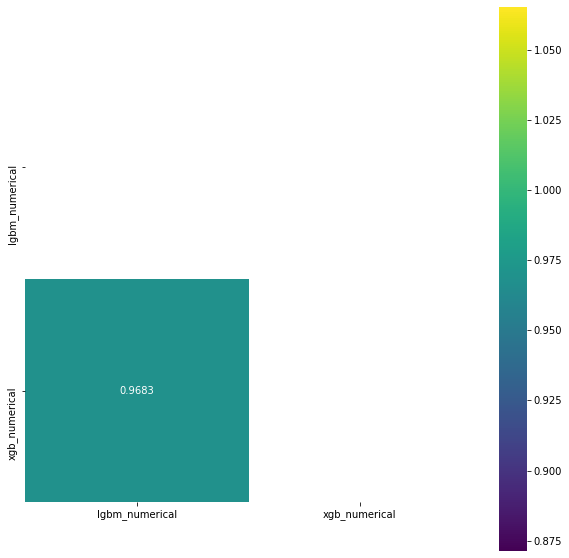

In [119]:
fig, axes = plt.subplots(1, 1, figsize=(10, 10))
sns.heatmap(corr, mask=mask, annot=True, fmt=".4g", square=True, cmap="viridis", ax=axes)

In [120]:
y_pred_xgb = np.zeros(df_test_merged.shape[0])
dtest = xgb.DMatrix(data=df_test_merged)

for estimator in xgb_estimators:
    y_pred_xgb += estimator.predict(dtest)
    
y_pred_xgb = pd.DataFrame({
    "APPLICATION_NUMBER": test_id,
    "TARGET": y_pred_xgb / cv.n_splits
})

In [121]:
x_train, x_valid = train_test_split(
    df_train_merged, train_size=0.7, random_state=1
)
y_train, y_valid = train_test_split(
    target, train_size=0.7, random_state=1
)

In [122]:
params = {
    "booster": "gbtree",
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "learning_rate": 0.1,
    "n_estimators": 600,
    "reg_lambda": 100,
    "max_depth": 7,
    "gamma": 10,
    "nthread": 6,
    "seed": 27,
    'colsample_bytree': 0.555,
    'min_child_weights': 369
}

In [123]:
dtrain = xgb.DMatrix(
    data=x_train, label=y_train
)
dvalid = xgb.DMatrix(
    data=x_valid, label=y_valid
)

In [124]:
model_xgb = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=6000,
    evals=[(dtrain, "train"), (dvalid, "valid")],
    early_stopping_rounds=500,
    verbose_eval=100,
)

[21:31:48] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { min_child_weights, n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-auc:0.60920	valid-auc:0.60980
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 500 rounds.
[100]	train-auc:0.73872	valid-auc:0.72453
[200]	train-auc:0.74364	valid-auc:0.72637
[300]	train-auc:0.74364	valid-auc:0.72637
[400]	train-auc:0.74364	valid-auc:0.72637
[500]	train-auc:0.74364	valid-auc:0.72637
[600]	train-auc:0.74364	valid-auc:0.72637
[700]	train-auc:0.74365	valid-auc:0.72667
[800]	train-auc:0.74441	valid-auc:0.72683
[900]	train-auc:0.74457	valid-auc:0.72678
[1000]	train-auc:0.74518	vali

In [125]:

train_score = roc_auc_score(y_train, model_xgb.predict(dtrain))
valid_score = roc_auc_score(y_valid, model_xgb.predict(dvalid))

print(f"Train-score: {round(train_score, 3)}, Valid-score: {round(valid_score, 3)})")

Train-score: 0.747, Valid-score: 0.727)


In [127]:
y_pred_xgb_model = model_xgb.predict(xgb.DMatrix(data=df_test_merged))
y_pred_xgb_model = pd.DataFrame({
    "APPLICATION_NUMBER": df_test_merged['APPLICATION_NUMBER'],
    "TARGET": y_pred_xgb_model.flatten(),})
y_pred_xgb_model["APPLICATION_NUMBER"] = y_pred_xgb_model["APPLICATION_NUMBER"].astype(int)

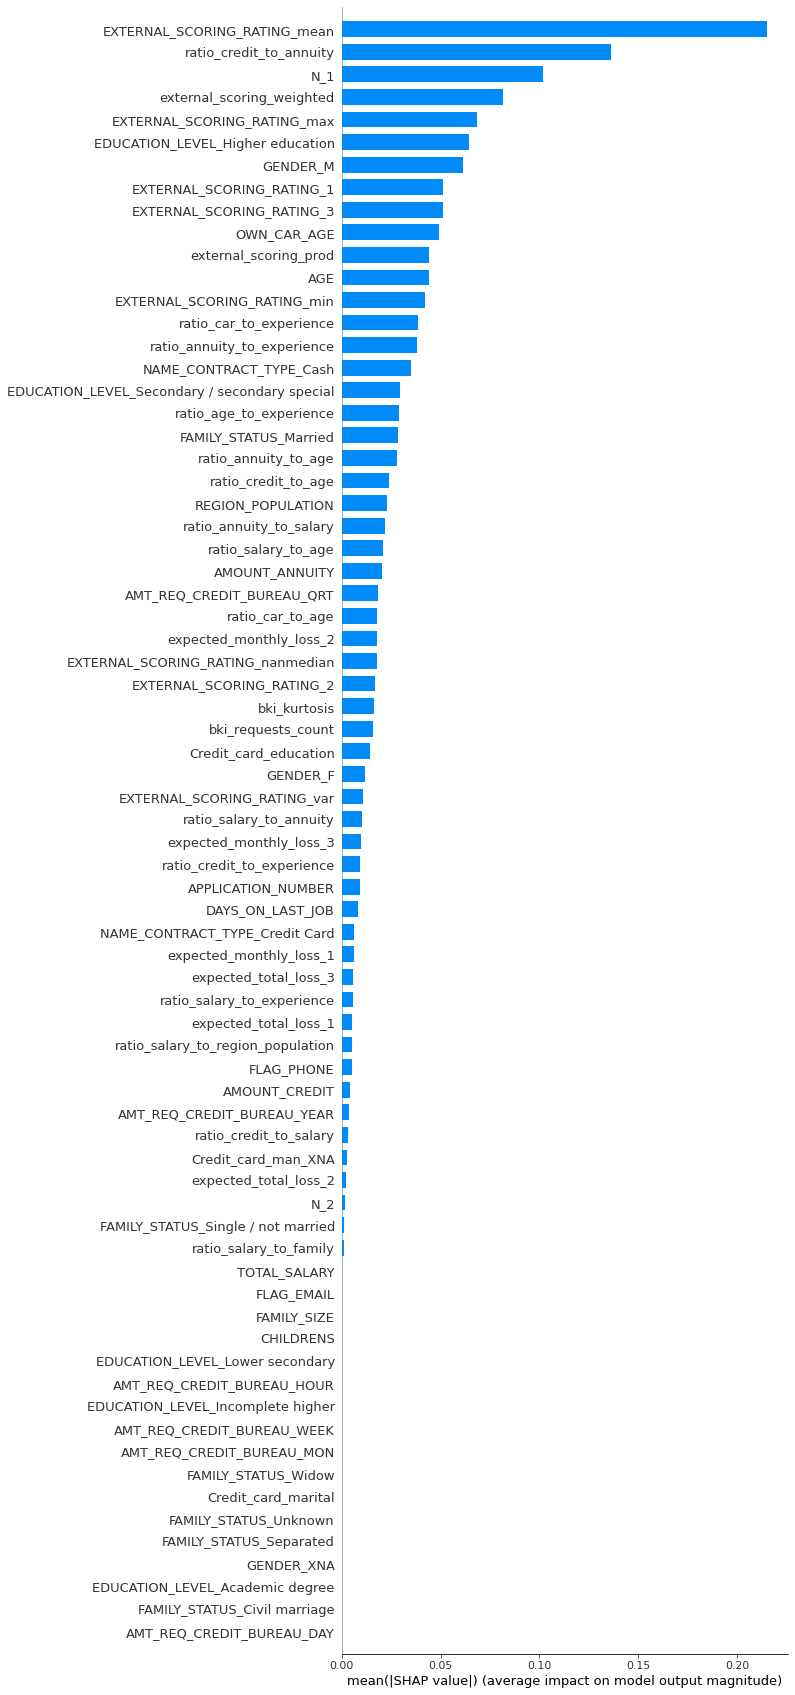

In [128]:
explainer = shap.TreeExplainer(model_xgb)
shap_values = explainer.shap_values(dvalid, y_valid)
shap.summary_plot(shap_values, x_valid, plot_type="bar", max_display=x_valid.shape[1])

In [129]:
to_drop = list(pd.DataFrame({'name': x_valid.columns, 'importance': np.mean(np.abs(shap_values), axis=0)}
                              ).sort_values(by='importance', ascending=False).reset_index(drop=True).tail(50)['name'])
to_drop

['ratio_annuity_to_salary',
 'ratio_salary_to_age',
 'AMOUNT_ANNUITY',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'ratio_car_to_age',
 'expected_monthly_loss_2',
 'EXTERNAL_SCORING_RATING_nanmedian',
 'EXTERNAL_SCORING_RATING_2',
 'bki_kurtosis',
 'bki_requests_count',
 'Credit_card_education',
 'GENDER_F',
 'EXTERNAL_SCORING_RATING_var',
 'ratio_salary_to_annuity',
 'expected_monthly_loss_3',
 'ratio_credit_to_experience',
 'APPLICATION_NUMBER',
 'DAYS_ON_LAST_JOB',
 'NAME_CONTRACT_TYPE_Credit Card',
 'expected_monthly_loss_1',
 'expected_total_loss_3',
 'ratio_salary_to_experience',
 'expected_total_loss_1',
 'ratio_salary_to_region_population',
 'FLAG_PHONE',
 'AMOUNT_CREDIT',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'ratio_credit_to_salary',
 'Credit_card_man_XNA',
 'expected_total_loss_2',
 'N_2',
 'FAMILY_STATUS_Single / not married',
 'ratio_salary_to_family',
 'FAMILY_STATUS_Widow',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'TOTAL_SALARY',
 'FLAG_EMAIL',
 'FAMILY_SIZE',
 'AMT_REQ_CREDIT_BUREAU_HOUR',
 'AMT_RE

In [130]:
x_train_shap = x_train.drop(to_drop, axis=1)
x_valid_shap = x_valid.drop(to_drop, axis=1)

In [131]:
dtrain = xgb.DMatrix(x_train_shap, label=y_train)
dvalid = xgb.DMatrix(x_valid_shap, label=y_valid)

In [132]:
xgb_estimators2, _, xgb_oof2 = xgboost_cross_validation(
    xgb_params, df_train_merged.drop(to_drop, axis=1), target, xgb_cv
)

Tue Dec 22 21:41:23 2020, Cross-Validation, 110093 rows, 22 cols
[21:41:23] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { random_seed } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-auc:0.68558	valid-auc:0.69657
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 25 rounds.
[10]	train-auc:0.70697	valid-auc:0.72305
[20]	train-auc:0.70976	valid-auc:0.72551
[30]	train-auc:0.71372	valid-auc:0.72815
[40]	train-auc:0.71517	valid-auc:0.72999
[50]	train-auc:0.71862	valid-auc:0.73115
[60]	train-auc:0.72101	valid-auc:0.73269
[70]	train-auc:0.72378	valid-auc:0.73550
[80]	train-auc:0.72719	valid-auc:0.73860
[90]	train-auc:0.73002	valid-auc:0.

[150]	train-auc:0.74160	valid-auc:0.73425
[160]	train-auc:0.74237	valid-auc:0.73462
[170]	train-auc:0.74319	valid-auc:0.73472
[180]	train-auc:0.74392	valid-auc:0.73563
[190]	train-auc:0.74485	valid-auc:0.73536
[200]	train-auc:0.74544	valid-auc:0.73572
[210]	train-auc:0.74583	valid-auc:0.73572
[220]	train-auc:0.74727	valid-auc:0.73636
[230]	train-auc:0.74788	valid-auc:0.73628
[240]	train-auc:0.74838	valid-auc:0.73667
[250]	train-auc:0.74875	valid-auc:0.73670
[260]	train-auc:0.74942	valid-auc:0.73693
[270]	train-auc:0.74962	valid-auc:0.73690
Stopping. Best iteration:
[254]	train-auc:0.74909	valid-auc:0.73721

Fold 5, Valid score = 0.73681
[21:42:35] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { random_seed } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an

[0]	train-auc:0.68994	valid-auc:0.68183
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 25 rounds.
[10]	train-auc:0.71234	valid-auc:0.68849
[20]	train-auc:0.71422	valid-auc:0.69100
[30]	train-auc:0.71711	valid-auc:0.69075
[40]	train-auc:0.71888	valid-auc:0.69199
[50]	train-auc:0.72128	valid-auc:0.69324
[60]	train-auc:0.72422	valid-auc:0.69597
[70]	train-auc:0.72739	valid-auc:0.69717
[80]	train-auc:0.73150	valid-auc:0.69987
[90]	train-auc:0.73377	valid-auc:0.70148
[100]	train-auc:0.73630	valid-auc:0.70351
[110]	train-auc:0.73895	valid-auc:0.70509
[120]	train-auc:0.74087	valid-auc:0.70655
[130]	train-auc:0.74245	valid-auc:0.70708
[140]	train-auc:0.74367	valid-auc:0.70833
[150]	train-auc:0.74478	valid-auc:0.70842
[160]	train-auc:0.74598	valid-auc:0.70955
[170]	train-auc:0.74703	valid-auc:0.70954
[180]	train-auc:0.74764	valid-auc:0.70968
[190]	train-auc:0.74825	valid-auc:0.71001
[200]	train-auc:0.74915	vali

In [133]:
score = roc_auc_score(target, xgb_oof2)
print(f"Score = {round(score, 4)}")

Score = 0.7289


In [134]:
y_pred_xgb2 = np.zeros(df_test_merged.drop(to_drop, axis=1).shape[0])
dtest = xgb.DMatrix(data=df_test_merged.drop(to_drop, axis=1))

for estimator in xgb_estimators2:
    y_pred_xgb2 += estimator.predict(dtest)
    
y_pred_xgb2 = pd.DataFrame({
    "APPLICATION_NUMBER": test_id,
    "TARGET": y_pred_xgb2 / cv.n_splits
})

In [135]:
model_xgb2 = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=6000,
    evals=[(dtrain, "train"), (dvalid, "valid")],
    early_stopping_rounds=500,
    verbose_eval=100,
)

[21:43:59] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { min_child_weights, n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-auc:0.57626	valid-auc:0.57690
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 500 rounds.
[100]	train-auc:0.73616	valid-auc:0.72548
[200]	train-auc:0.73791	valid-auc:0.72600
[300]	train-auc:0.73859	valid-auc:0.72605
[400]	train-auc:0.73916	valid-auc:0.72634
[500]	train-auc:0.73958	valid-auc:0.72656
[600]	train-auc:0.73958	valid-auc:0.72656
[700]	train-auc:0.73958	valid-auc:0.72656
[800]	train-auc:0.73958	valid-auc:0.72656
[900]	train-auc:0.73958	valid-auc:0.72656
Stopping. Best iteration:
[48

In [136]:

train_score = roc_auc_score(y_train, model_xgb2.predict(dtrain))
valid_score = roc_auc_score(y_valid, model_xgb2.predict(dvalid))

print(f"Train-score: {round(train_score, 3)}, Valid-score: {round(valid_score, 3)})")

Train-score: 0.74, Valid-score: 0.727)


In [138]:
y_pred_xgb_model2 = model_xgb2.predict(xgb.DMatrix(data=df_test_merged.drop(to_drop, axis=1)))
y_pred_xgb_model2 = pd.DataFrame({
    "APPLICATION_NUMBER": df_test_merged['APPLICATION_NUMBER'],
    "TARGET": y_pred_xgb_model2.flatten(),})
y_pred_xgb_model2["APPLICATION_NUMBER"] = y_pred_xgb_model2["APPLICATION_NUMBER"].astype(int)

In [141]:
res = y_pred1.copy()
res['TARGET'] = (y_pred1['TARGET'] + y_pred2['TARGET'] + y_pred_xgb2['TARGET']) / 3
res.head()
res.to_csv("Kaldin_res_13.csv", index=False)

In [142]:
res = y_pred1.copy()
res['TARGET'] = 0.3*(y_pred1['TARGET']) + 0.2*(y_pred2['TARGET']) + 0.5*(y_pred_xgb2['TARGET'])
res.head()
res.to_csv("Kaldin_res_14.csv", index=False)

In [ ]:
y_pred1 - Score = 0.7263
y_pred2 - Score = 0.7277
y_pred_xgb - Score = 0.7259
y_pred_xgb2 - Score = 0.7275
y_pred_xgb_model - Valid-score: 0.727
y_pred_xgb_model2 - Valid-score: 0.726
    
    
    y_pred1 - Score = 0.7282
    y_pred2 - Score = 0.7278
    y_pred_xgb - Score = 0.727
    y_pred_xgb2 - Score = 0.7289
    y_pred_xgb_model - Valid-score: 0.727
    y_pred_xgb_model2 - Valid-score: 0.727
